# Exercise instructions
1.  You must answer the questions at the beginning of each paragraph  
2.  You must complete the code between #...#
3.  You must explain in comments the lines of code that you produce
4.  You can help and ask for help from others but you must indicate the person who helped you

# Références
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/utils.py



# Dataset
https://research.aimultiple.com/datasets-for-ml/

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pdb
import torchvision
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [2]:
project_path = "/kaggle/working/"
data_set_path = "/kaggle/input/dl-assignment-data/"
TRAIN_IMG_DIR = os.path.join(data_set_path,"train_frames/train_frames/train")
TRAIN_MASK_DIR = os.path.join(data_set_path,"train_masks/train_masks/train")
VAL_IMG_DIR = os.path.join(data_set_path,"val_frames/val_frames/val")
VAL_MASK_DIR = os.path.join(data_set_path,"val_masks/val_masks/val")
TEST_IMG_DIR = os.path.join(data_set_path,"test_frames/test_frames/test")
TEST_MASK_DIR = os.path.join(data_set_path,"test_masks/test_masks/test")

CHECKPOINT_PATH = os.path.join(project_path,"Save/my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path,"Save/Accuracy")
PLOT_VAL_PATH = os.path.join(project_path,"Save/validation")

In [3]:
TRAIN_IMG_DIR

'/kaggle/input/dl-assignment-data/train_frames/train_frames/train'

## Dataset Class
Questions:
1. Explain what the get_item function is for and how it is called in training mechanism?
2. why do we have to divide mask by 255?


# Answers:

**1**.The __get_item__ function in a PyTorch dataset class is used to retrieve a specific item from the dataset like here the images and mask at a given index. It is called during training or evaluation mechanisms, typically within a training loop, to fetch a training sample (image input data and corresponding labels which mask in our case) for a particular iteration.

**2**.When dividing the mask by 255, it's a common practice in image processing, especially in tasks like semantic segmentation. In images, pixel values are usually integers within the [0, 255] range. Normalizing the mask involves dividing each pixel value by 255, effectively scaling them to the range [0, 1]. This normalization is crucial for compatibility with neural networks, which typically expect input data within the [0, 1] range. I find it beneficial to adhere to this convention for consistency between input images and masks. It simplifies implementation and helps avoid potential issues during training. In the context of semantic segmentation, where masks  represent binary segmentation, this normalization ensures effective use of neural network layers and activation functions. The line `mask = mask / 255.0` in the code ensures that the mask values conform to this normalized scale.

(512, 640)


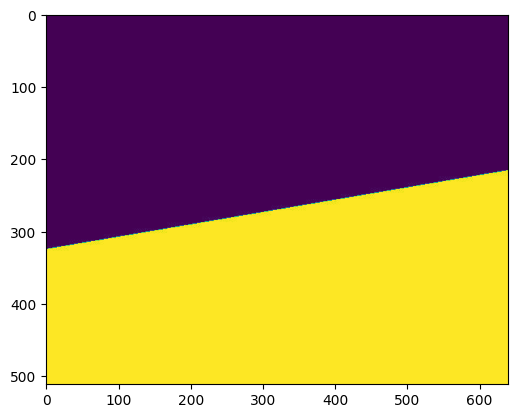

In [4]:
from PIL import Image 
im = Image.open('/kaggle/input/dl-assignment-data/train_masks/train_masks/train/train_00000.jpg')
image_arr= np.array(im)
plt.imshow(np.mean(image_arr,axis = 2))
print(np.mean(image_arr,axis = 2).shape)

In [5]:
from torchvision.io import read_image
from torchvision.transforms.functional import to_tensor

class HorizonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])

        # Load image and mask using PIL (Python Imaging Library)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Convert PIL images to numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Normalize mask values to [0, 1]
        mask = mask / 255.0

        if self.transform is not None:
            # Apply augmentations if specified
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask



In [6]:
#test_ds[0][1].shape

## Loader definition
Questions:
1. Explain what the data loader is for?

**1**.A **data loader** in PyTorch acts like a helpful assistant, efficiently handling the loading of data batches during neural network training or evaluation. It takes care of tasks like parallel loading, shuffling during training, and grouping samples into batches. The `get_loaders` function in my code creates training and validation data loaders, simplifying the process of managing and feeding data to the neural network during different phases. The training loader shuffles data for effective learning, while the validation loader ensures consistent evaluation. These loaders are essential for handling datasets seamlessly in machine learning tasks.



In [7]:
# The data loader allows you to iterate over the dataset.
# Each iteration below returns a batch of train_features and train_labels

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HorizonDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

# Warning to shuffle (true or false ??? explain why in commentary)
    train_loader = DataLoader(train_ds,batch_size=16,shuffle = True)

    val_ds = HorizonDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )
    # Shuffling the data ensures that the order of the training samples does not impact the learning process. 
    #If the data were ordered in a specific way, the model might learn patterns related to that order, and it may not generalize well to unseen data.
# Warning to shuffle (true or false ??? explain why in commentary)
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,  # Do not shuffle the data during validation,
                        #avoiding shuffling during validation for consistent evaluation
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    return train_loader, val_loader


- **Shuffling During Training (True):** Setting `shuffle=True` during training is a good practice for better generalization of the model. Shuffling the data helps prevent the model from learning patterns based on the order of the samples in each epoch. If the data has some inherent order (e.g., sorted by class labels), shuffling ensures that the model doesn't inadvertently learn from this order and improves its ability to generalize well to unseen data.

- **Not Shuffling During Validation (False):** On the other hand, during validation, we typically don't shuffle the data (`shuffle=False`). This is because during validation, we want the model to make predictions on the data in a consistent manner. Shuffling during validation could make it challenging to assess the model's performance consistently, especially when comparing results between different validation runs.

So, the warning comment emphasizes the importance of shuffling during training for better generalization, while avoiding shuffling during validation for consistent evaluation.

# Model definition
https://www.pinecone.io/learn/batch-layer-normalization/

https://medium.com/data-science-365/batch-normalization-explained-in-plain-english-3436014f9e52

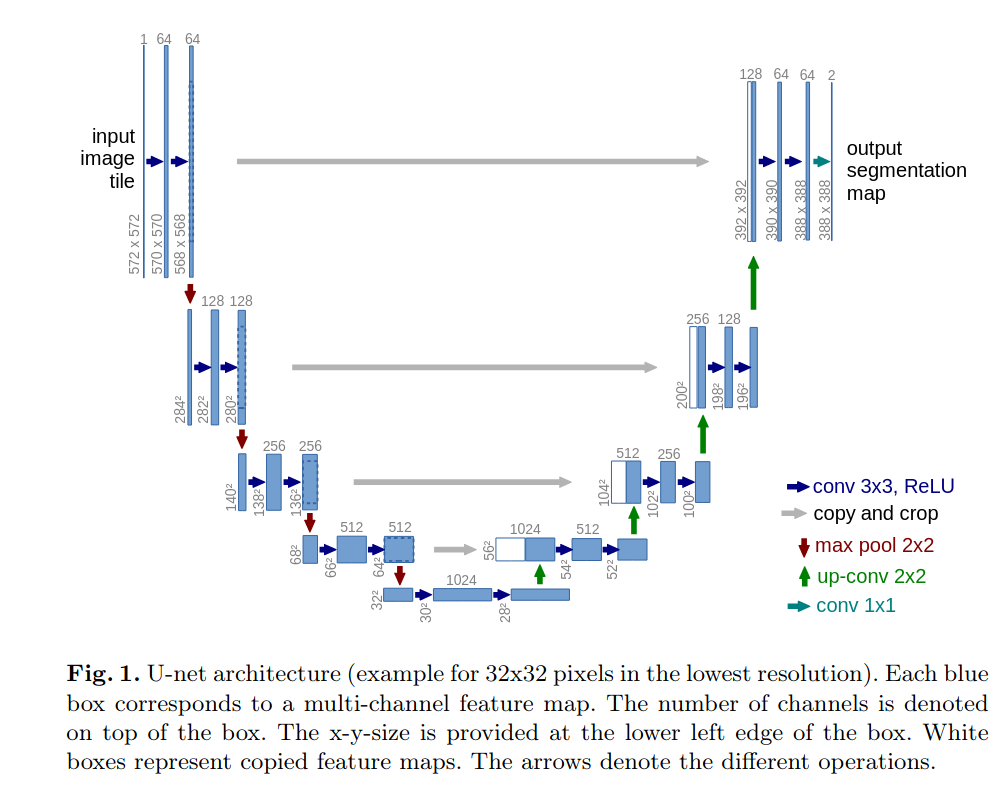

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# explain the line of code below
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Double convolution
Questions:
1. From the network diagram above, code an elementary brick composed of a convolution layer.Do the same but limiting to a single convolution layer.

# Answer:
I use the line of code `DEVICE = "cuda" if torch.cuda.is_available() else "cpu"` to dynamically set the variable `DEVICE` to either "cuda" or "cpu" based on whether a GPU with CUDA support is available on my system. This approach ensures that my PyTorch model utilizes a GPU if one is present for faster computations, and defaults to the CPU if no GPU is available. It's a practical way to adapt my code to the hardware resources on my machine, providing flexibility for different computing environments.

In [9]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        # Define the convolutional layers in a sequential manner
        self.conv = nn.Sequential(
            # First convolutional layer with 3x3 kernel, stride of 1, padding of 1, and no bias
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            # Batch normalization for the output of the first convolution
            nn.BatchNorm2d(out_channels),
            # ReLU activation function applied in-place
            nn.ReLU(inplace=True),
            
            # Second convolutional layer with 3x3 kernel, stride of 1, padding of 1, and no bias
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            # Batch normalization for the output of the second convolution
            nn.BatchNorm2d(out_channels),
            # ReLU activation function applied in-place
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through the defined convolutional layers
        return self.conv(x)


In [10]:
class SimpleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleConv, self).__init__()
        
        # Define a simple convolutional layer followed by batch normalization and ReLU activation
        self.conv = nn.Sequential(
            # Convolutional layer with 3x3 kernel, stride of 1, padding of 1, and no bias
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            # Batch normalization for the output of the convolutional layer
            nn.BatchNorm2d(out_channels),
            # ReLU activation function applied in-place
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through the defined convolutional layers
        return self.conv(x)


## Model
https://arxiv.org/pdf/1505.04597.pdf

Questions :
1.  Complete the model code from the publication schema.
2.  Complete the descending part then the rising part of the Unet.
3.  For the rising part, use ConvTranspose2d
4.  Use the DoubleConv function first and then the SimpleConv, make comments

# Answers:

1. **DoubleConv and SimpleConv:**
   - These are utility classes defining blocks with two convolutional layers and a simple convolutional layer, respectively, followed by batch normalization and ReLU activation.

2. **UNET Class:**
   - The UNET class is designed for semantic segmentation tasks using a U-Net architecture.
   - The `__init__` method sets up the architecture with downsampling and upsampling paths.
   - The `forward` method implements the forward pass, where input data passes through the down and up parts of the network, and skip connections are concatenated during the upsampled path.
   - The final output is obtained through a 1x1 convolution.

3. **Down and Up Paths:**
   - The down path consists of DoubleConv blocks followed by max-pooling for downsampling.
   - The up path consists of transposed convolutions (upsampling) and concatenation with skip connections from the down path.

4. **Bottleneck:**
   - The bottleneck is a simple convolutional block applied after the down path.

5. **Final Convolution:**
   - The final convolution reduces the number of channels to the desired output channels (e.g., 1 for binary segmentation).

In [11]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = SimpleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            # Concatenate skip connection and upsampled feature map
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip) if idx+1 < len(self.ups) else x 

        return self.final_conv(x)

# Evaluation metric
Evaluation metrics are quantitative measures used to assess the performance and effectiveness of a statistical or machine learning model. These metrics provide insights into how well the model is performing and help in comparing different models or algorithms.

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

Q: Write a function which calculates the accuracy which is the number of pixels OK compared to the total number of pixels and which calculates the dice score. This function will return the dice score as a validation metric.
Comment on the use of model.eval() and model.train()

# Answer:
When we use **model.eval()**, it sets the model to this prediction mode, turning off certain things that add randomness, such as dropout. Also, for layers that kept track of statistics during training (like batch normalization), it makes sure they use these learned statistics without changing them. It's like telling the model to be on its best behavior and make predictions as consistently as possible, based on what it learned during training. This helps to ensure that the predictions are reliable when we use the model on new, unseen data. \
On the other hand, When we use **model.train()**, it sets the model to this learning mode. In this mode, special layers like dropout and batch normalization become active. Dropout layers start randomly dropping some parts of the model during each learning step, introducing a bit of randomness to prevent the model from relying too much on specific features. Batch normalization layers use statistics calculated within each mini-batch of training data, helping the model adapt to different patterns present in the data.

In [13]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # This sets the model to evaluation mode, deactivating layers such as dropout and bypassing mini-batch normalization.

    with torch.no_grad():
        for x, y in loader:

          x ,y = x.to(device), y.to(device)
          y_pred = torch.sigmoid(model(x))
          y_pred = (y_pred > 0.5).float()
          intersection = torch.sum(y_pred * y)        # Get the pixels common in prediction and label
          union = torch.sum(y_pred) + torch.sum(y)    # Get the sum of pixels in prediction and label
          dice = 2 * intersection/ (union + 1e-8)     # Calculate the dice coefficient

          dice_score += dice.item()
          num_correct += (y_pred == y).sum().item()    # Get the pixels correctly classified
          num_pixels += torch.numel(y)        # Get the total number of pixels

            #...""


          #The Dice coefficient, utilized to gauge the pixel-level similarity between a predicted segmentation and its actual ground truth,
          #is calculated as twice the area of overlap divided by the combined pixel count of both images.


    #...#
    val_accuracy = dice_score/len(loader)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {val_accuracy}")
    model.train()

    return val_accuracy

# Comment : 

When we set the model in training mode via model.train(), it means we're preparing our model for training, and this will activate the behaviors specific to training, such as dropout or batch normalization, which ensure randomness and generalization during training. In this mode, the model returns a 3-element list related to the training process.

On the other hand, when we set the model in evaluation mode, that is model.eval(), the model is prepared for inference or evaluation. In this mode, any randomness introduced by dropout or batch normalization is switched off to ensure deterministic outputs for the same input. This stage returns a 2-element tuple, more streamlined and preparation for final output after post-processing.

The difference in the number of elements reflects the different levels of information required at different stages in the modeling process. With model.train(), we generally need more detailed, layer-level information which might be used for back-propagation and gradient updates. Conversely, with model.eval(), we typically only require the final output of the model.

As for the question regarding the second element of tuple and elements in the train-status model list: while they broadly correspond in terms of what they represent (activation outputs, for instance), the specific values are different due to the aforementioned behaviors activated in train and eval modes.

So, if we're training a model, model.train() is the appropriate mode. However, if we're evaluating or doing inference with a model, we'd want to switch to using model.eval().

# Training
https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/

In [15]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
# TRAIN_IMG_DIR = "/kaggle/input/dl-assignment-data/train_frames/train_frames/train"
# TRAIN_MASK_DIR = "/kaggle/input/dl-assignment-data/train_masks/train_masks/train"
# VAL_IMG_DIR = "/kaggle/input/dl-assignment-data/test_frames/test_frames/test"
# VAL_MASK_DIR = "/kaggle/input/dl-assignment-data/test_masks/test_masks/test"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Hyper parameters

In [16]:
class HyperParameters:
    def __init__(self, learning_rate, batch_size,epoch_numbers):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_numbers = epoch_numbers

## Train function
Qestions
1. Write a function that calculates the loss on validation data.
2. Write a function that saves an image and the network prediction for each epoch to visualize the learning progress.
3. Write a function that calculates the loss on training data.
4. Make a comment on optimizer.zero_grad(), scaler.scale(loss).backward(),scaler.step(optimizer), scaler.update()



### Comments: 

- **`optimizer.zero_grad()`**:
  - **Purpose:** Clears the gradients of all optimized parameters.
  - **Effect:** Necessary before computing gradients for the next batch to avoid accumulation of gradients from previous batches.

- **`scaler.scale(loss).backward()`**:
  - **Purpose:** Performs the backward pass to compute gradients.
  - **Effect:** Scales the loss value to avoid numerical instability in case of very small or very large gradients.

- **`scaler.step(optimizer)`**:
  - **Purpose:** Updates the model parameters using the computed gradients.
  - **Effect:** Optimizes the model parameters using the specified optimizer.

- **`scaler.update()`**:
  - **Purpose:** Updates the internal scale for the next iteration.
  - **Effect:** Adjusts the scaling factor based on the gradient values to maintain numerical stability during training.

In [17]:
!mkdir Save

In [18]:
def check_val_loss(loader, model, loss_fn, device="cuda"):
    # Initialize the total validation loss
    total_val_loss = 0.0

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation during validation
    with torch.no_grad():
        # Iterate through the validation loader
        for data, targets in loader:
            # Move data and targets to the specified device
            data, targets = data.to(device), targets.float().unsqueeze(1).to(DEVICE)

            # Forward pass to obtain predictions
            predictions = model(data)

            # Calculate the loss between predictions and targets
            loss = loss_fn(predictions, targets)

            # Accumulate the validation loss
            total_val_loss += loss.item()

    # Calculate the average validation loss
    val_loss = total_val_loss / len(loader)

    # Print the average validation loss
    print(f"Validation loss: {val_loss}")

    # Set the model back to training mode
    model.train()

    return val_loss

def save_eval(loader, model, epoch, file_path="eval_image", device="cuda"):
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Get a batch of validation images and masks
        val_images, val_masks = next(iter(loader))
        val_images = val_images.to(device)

        # Generate a filename based on the epoch
        filename = f"{file_path}_{epoch}"

        # Forward pass to obtain predictions
        predictions = model(val_images)
        preds = torch.sigmoid(predictions)

        # Save images and predictions (visualization code should be added here)
        for idx in range(val_images.size(0)):
            plt.figure(figsize=(10, 5))
            
            # Ensure the image has shape (height, width, channels) for Matplotlib
            original_image = val_images[idx].permute(1, 2, 0).cpu().numpy()
            prediction_image = preds[idx].squeeze().cpu().numpy()

            plt.subplot(1, 2, 1)
            plt.imshow(original_image, cmap='bone')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(prediction_image, cmap='bone')
            plt.title('Prediction')

            plt.savefig(f"{file_path}_{epoch}_{idx}.png")
            plt.close()

    # Set the model back to training mode
    model.train()

In [19]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    # Create a tqdm loop for visualization during training
    loop = tqdm(loader)

    # Initialize the total training loss
    total_train_loss = 0.0

    # Iterate through the training data loader
    for batch_idx, (data, targets) in enumerate(loop):
        # Move data and targets to the appropriate device
        data = data.to(DEVICE)
        targets = targets.float().unsqueeze(1).to(DEVICE)

        # Forward pass
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_train_loss += loss

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop to display the current loss
        loop.set_postfix(loss=loss.item())

    # Calculate the average training loss
    train_loss = total_train_loss / len(loader)

    # Print the average training loss
    print(f"Train loss: {train_loss}")

    return train_loss



## Training script
Questions:
1. Write a function wich plot and save train_loss, val_loss and val_acc
2. Write a function which save ckeckpoint file
3. Make a comment on:
A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )
4.  Why are transformations missing for validation data?
5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?
6.  Make a comment on: torch.cuda.amp.GradScaler()
7.  What is Adam? What’s the main difference between Adam and SGD?


# Answers:

### 3. Comment on Augmentation Transformations:

- **A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH):**
  - Resizes the images to a specified height and width.

- **A.Rotate(limit=35, p=1.0):**
  - Rotates the images by a random angle up to the specified limit (in degrees) with a probability of 1.0.

- **A.HorizontalFlip(p=0.5):**
  - Horizontally flips the images with a 50% probability.

- **A.VerticalFlip(p=0.1):**
  - Vertically flips the images with a 10% probability.

- **A.Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0):**
  - Normalizes the pixel values of the images. It subtracts the mean and divides by the standard deviation, bringing the pixel values to a standard scale.

### 4. Why Are Transformations Missing for Validation Data?

  - Validation data often does not require data augmentation because the goal is to evaluate the model's performance on unseen, unaltered data. Transformations applied during training aim to increase model robustness and generalize well to various inputs. For validation, the focus is on assessing the model's inherent ability to generalize.

### 5. Why `nn.BCEWithLogitsLoss()` is Used Instead of Classical BCE?

  - `nn.BCEWithLogitsLoss()` is often preferred when dealing with binary classification tasks because it combines the sigmoid activation (applied internally) and the binary cross-entropy loss in a numerically stable way. This helps avoid potential issues with vanishing/exploding gradients that might occur when using separate sigmoid activation and BCE loss.

### 6. Comment on `torch.cuda.amp.GradScaler()`

  - `torch.cuda.amp.GradScaler()` is used for mixed-precision training. It automatically scales the gradients to prevent underflow and overflow issues when using lower-precision data types like float16. This can lead to faster training without sacrificing numerical stability.

### 7. What is Adam? What’s the Main Difference Between Adam and SGD?
 - Adam (short for Adaptive Moment Estimation) is an optimization algorithm that combines ideas from momentum optimization and RMSprop. It maintains adaptive learning rates for each parameter and includes momentum-like terms to speed up convergence.
 - Main differences with SGD:
    - Adam adapts the learning rates individually for each parameter.
    - Adam incorporates momentum-like terms for faster convergence.
    - Adam maintains separate moving averages for the squared gradients, adjusting the learning rates dynamically.
    - SGD has a constant learning rate for all parameters and does not have built-in adaptive features.

In [20]:
import matplotlib.pyplot as plt

class Results:
    def __init__(self,file_path="results"):
        self.result_dict = {"train_loss": [],"val_loss": [],"val_acc": []}
        self.path = file_path
        
    def add_result(self,train_loss,val_loss,val_acc):
        self.result_dict["train_loss"].append(train_loss)
        self.result_dict["val_loss"].append(val_loss)
        self.result_dict["val_acc"].append(val_acc)
        
    def plotAndSave(self,n_epoch):
        filename = self.path +"_" +str(n_epoch)
        #..#



In [25]:
import matplotlib.pyplot as plt

class Results:
    def __init__(self, file_path="results"):
        # Initialize a dictionary to store training and validation results
        self.result_dict = {
            "train_loss": [],
            "val_loss": [],
            "val_acc": []
        }
        # Specify the path for saving results
        self.path = file_path

    def add_result(self, train_loss, val_loss, val_acc):
        # Add the provided results to the result_dict
        self.result_dict["train_loss"].append(train_loss)
        self.result_dict["val_loss"].append(val_loss)
        self.result_dict["val_acc"].append(val_acc)

    def plot_and_save(self, n_epoch):
        filename = self.path + "_" + str(n_epoch)
        train_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["train_loss"]]
        val_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_loss"]]
        val_acc_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_acc"]]

        # Create subplots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot Train Loss with blue color, using dots (markers) for each epoch
        axs[0].plot(np.arange(n_epoch + 1), train_loss_cpu, label='Train Loss', color='blue', marker='o')
        axs[0].set_title('Train Loss')
        axs[0].set_xlabel('Epoch')

        # Plot Validation Loss with orange color, using dots (markers) for each epoch
        axs[1].plot(np.arange(n_epoch + 1), val_loss_cpu, label='Validation Loss', color='orange', marker='o')
        axs[1].set_title('Validation Loss')
        axs[1].set_xlabel('Epoch')

        # Plot Validation Accuracy with green color, using dots (markers) for each epoch
        axs[2].plot(np.arange(n_epoch + 1), val_acc_cpu, label='Validation Accuracy', color='green', marker='o')
        axs[2].set_title('Validation Accuracy')
        axs[2].set_xlabel('Epoch')

        # Add legend and save the figure
        fig.legend()
        fig.savefig(f'{filename}.png')
        plt.show()

In [26]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint: ")
    print(filename)
    torch.save(state, filename)
    # Additional code for saving other relevant information if needed.
    
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    print("=> Checkpoint loaded successfully")

def run_training(hyper_parameters):

    # Initialize a Results object for tracking and visualizing training results
    results = Results(file_path=PLOT_PATH)

    # Define data transformations for training and validation
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    # Instantiate the model, define loss function, and choose optimizer
    model = UNET().to(DEVICE)#DoubleConv( in_channels=3, out_channels=1)# ... # Model instantiation code missing
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyper_parameters.learning_rate)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    # Get data loaders for training and validation
    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        hyper_parameters.batch_size,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    # Load pre-trained model if specified
    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    # Initial evaluation on validation data
    check_accuracy(val_loader, model, device=DEVICE)

    # Initialize gradient scaler for mixed-precision training
    scaler = torch.cuda.amp.GradScaler()

    # Main training loop
    for epoch in range(hyper_parameters.epoch_numbers):
        # Train the model for one epoch
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # Save model checkpoint
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_PATH)

        # Evaluate on validation data
        val_loss = check_val_loss(val_loader, model, loss_fn)
        # Check accuracy on validation data
        val_accuracy = check_accuracy(val_loader, model, device=DEVICE)

        # Add results to the Results object
        results.add_result(train_loss, val_loss, val_accuracy)

        # Plot and save training results
        results.plot_and_save(epoch)

        # Save additional evaluation results (e.g., images) for each epoch
        # epoch = epoch + 1  # or however you update the epoch variable in your loop
        save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device=DEVICE)
      


# Run Training

Got 232853806/117800960 with acc 197.67
Dice score: 2.65167481716218


100%|██████████| 450/450 [02:13<00:00,  3.38it/s, loss=0.108] 


Train loss: 0.10666169226169586
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.04924890273421572
Got 447992487/117800960 with acc 380.30
Dice score: 3.814356911103651


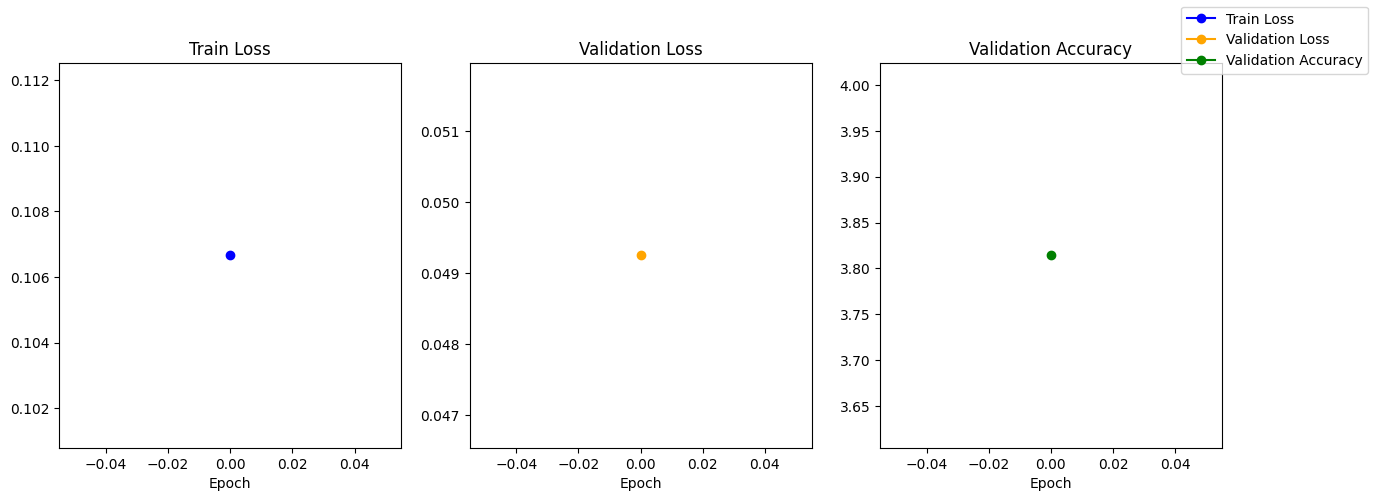

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.0217]


Train loss: 0.04091845452785492
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.031776173421501845
Got 447336574/117800960 with acc 379.74
Dice score: 3.80896825305034


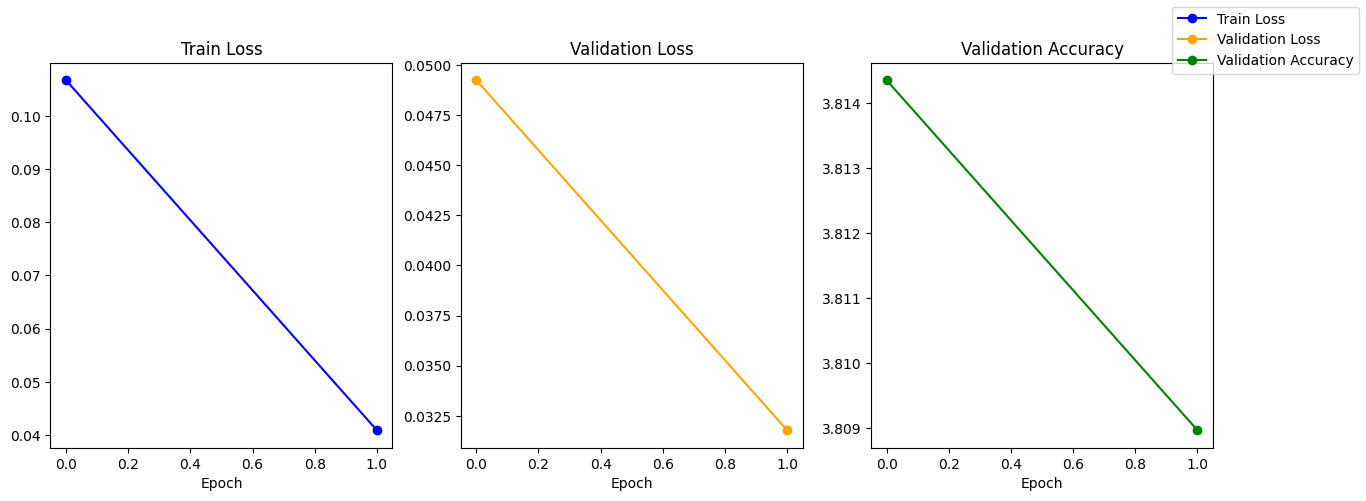

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.0152]


Train loss: 0.027355847880244255
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.01690224603179001
Got 448272718/117800960 with acc 380.53
Dice score: 3.817027126805386


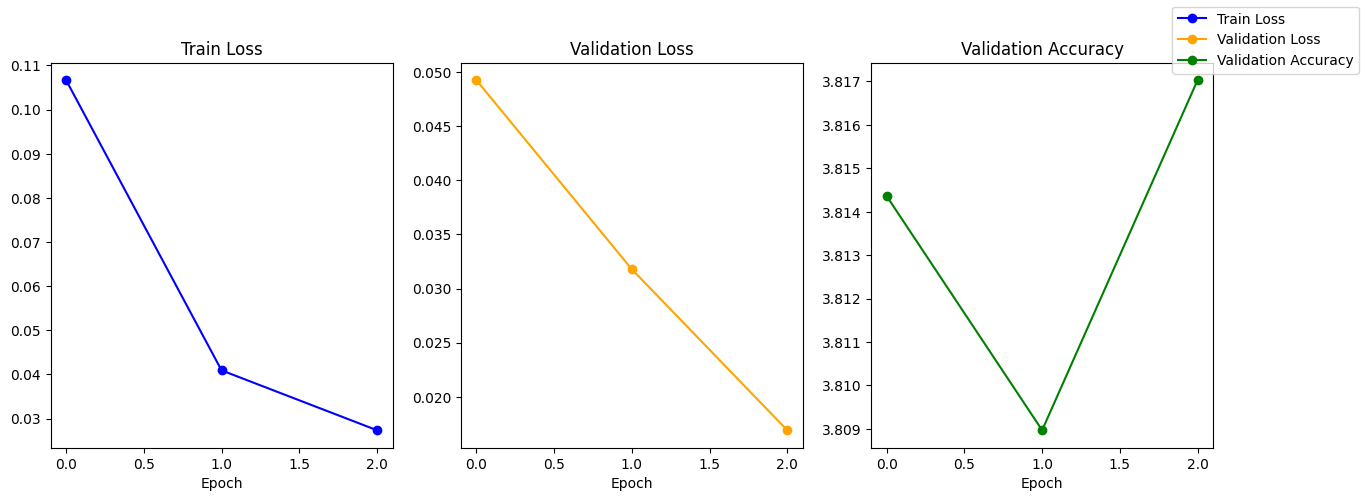

100%|██████████| 450/450 [02:12<00:00,  3.40it/s, loss=0.0252]


Train loss: 0.019103528931736946
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.014832102455347941
Got 447907995/117800960 with acc 380.22
Dice score: 3.8137251511408943


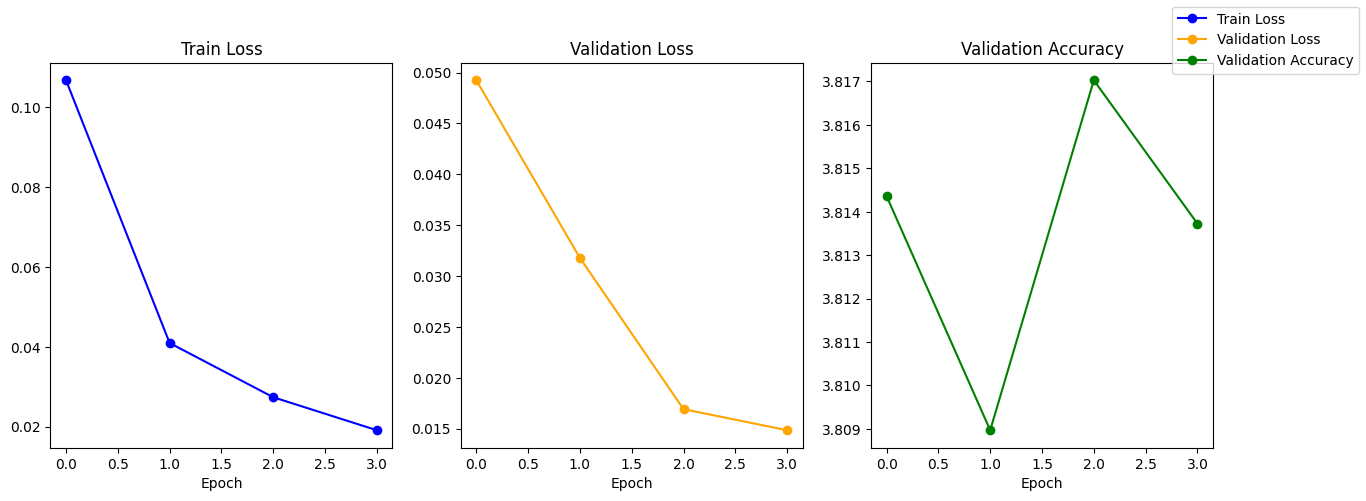

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.0206] 


Train loss: 0.016018005087971687
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.011861884086967775
Got 448124383/117800960 with acc 380.41
Dice score: 3.815760192408776


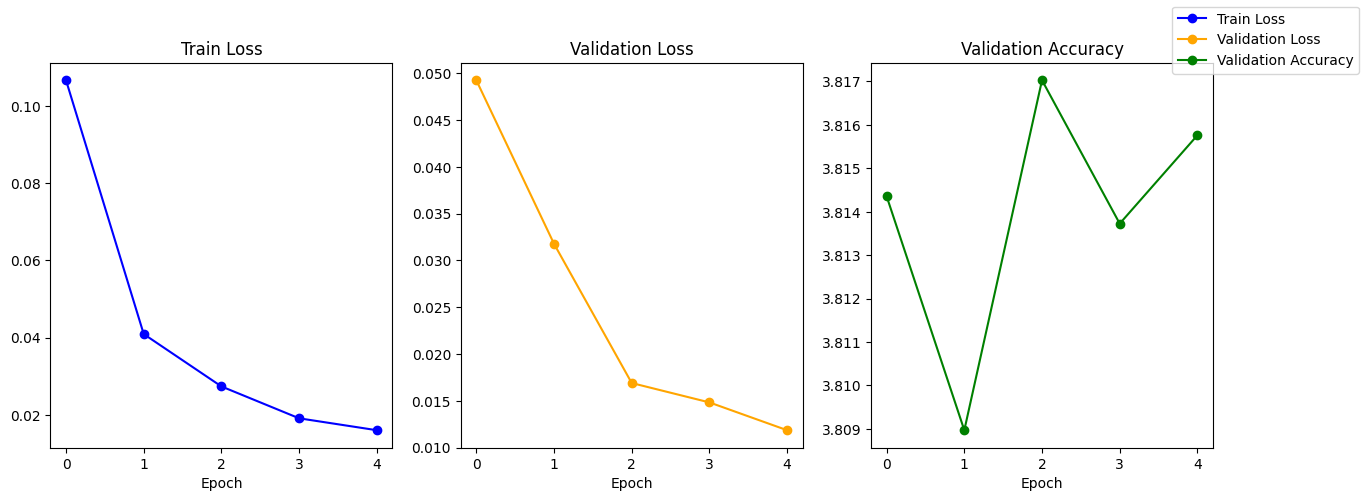

100%|██████████| 450/450 [02:09<00:00,  3.47it/s, loss=0.00619]


Train loss: 0.014114090241491795
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.00944938075244924
Got 448273327/117800960 with acc 380.53
Dice score: 3.8170690787913526


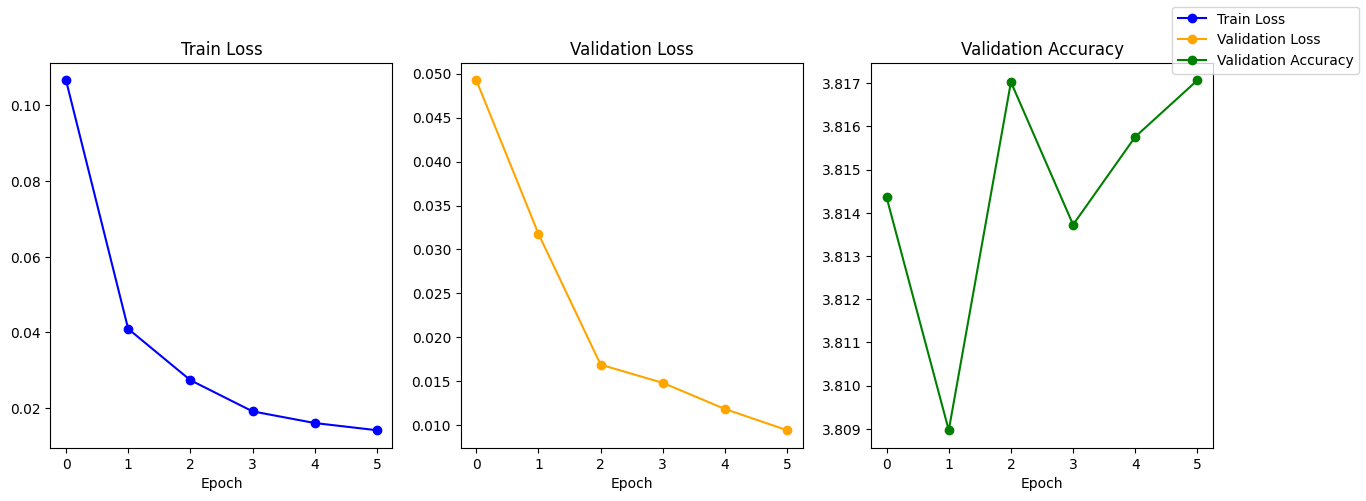

100%|██████████| 450/450 [02:09<00:00,  3.48it/s, loss=0.012]  


Train loss: 0.011397574096918106
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.00863243184788971
Got 448263566/117800960 with acc 380.53
Dice score: 3.816911324622705


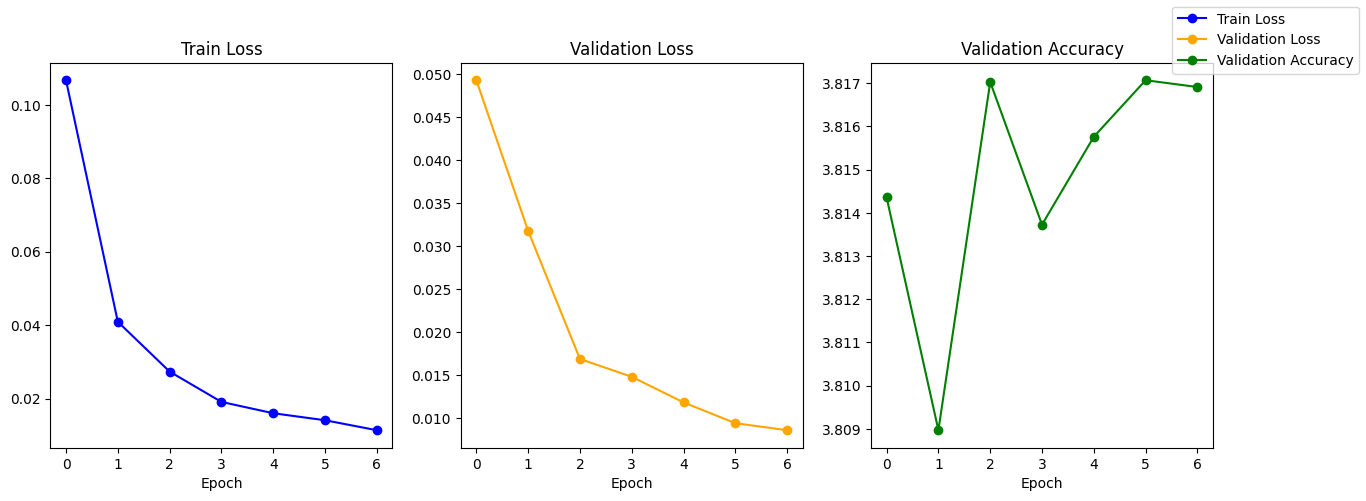

100%|██████████| 450/450 [02:09<00:00,  3.48it/s, loss=0.0092] 


Train loss: 0.012471729889512062
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.012133309773031675
Got 447439924/117800960 with acc 379.83
Dice score: 3.8104202153903968


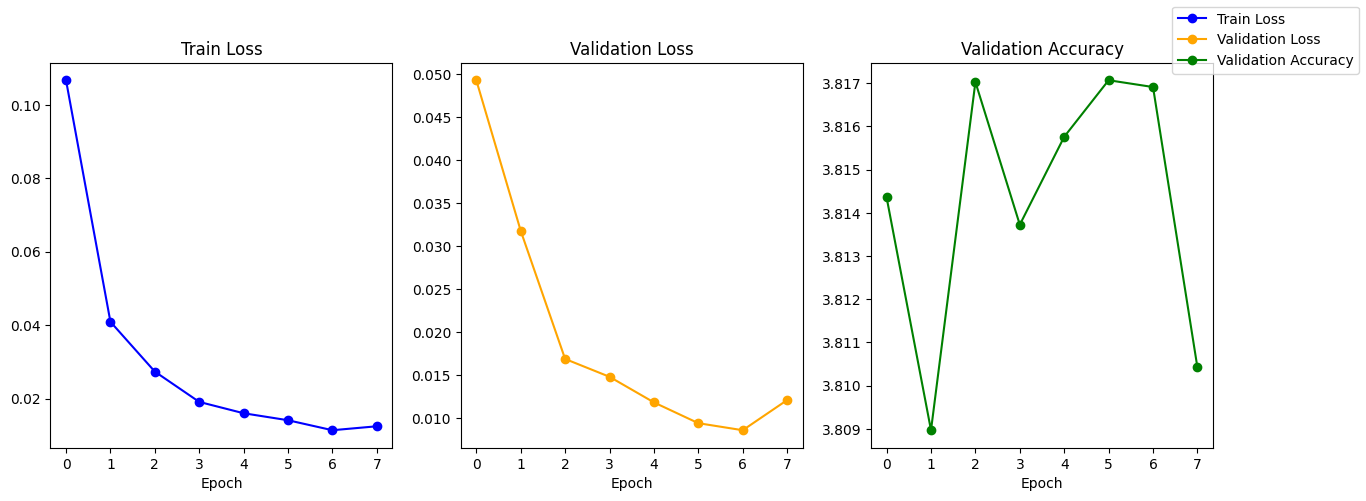

100%|██████████| 450/450 [02:09<00:00,  3.48it/s, loss=0.00566]


Train loss: 0.011686672456562519
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.009466157838426638
Got 448127826/117800960 with acc 380.41
Dice score: 3.815746129467847


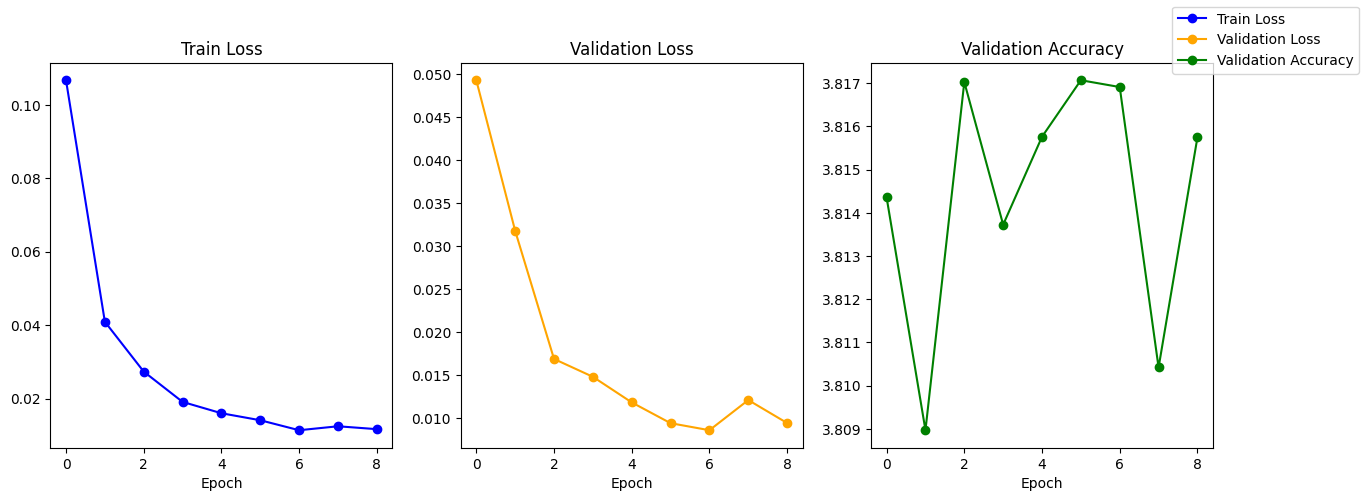

100%|██████████| 450/450 [02:10<00:00,  3.44it/s, loss=0.00758]


Train loss: 0.010311191901564598
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.007148768248044791
Got 448332006/117800960 with acc 380.58
Dice score: 3.817511716829616


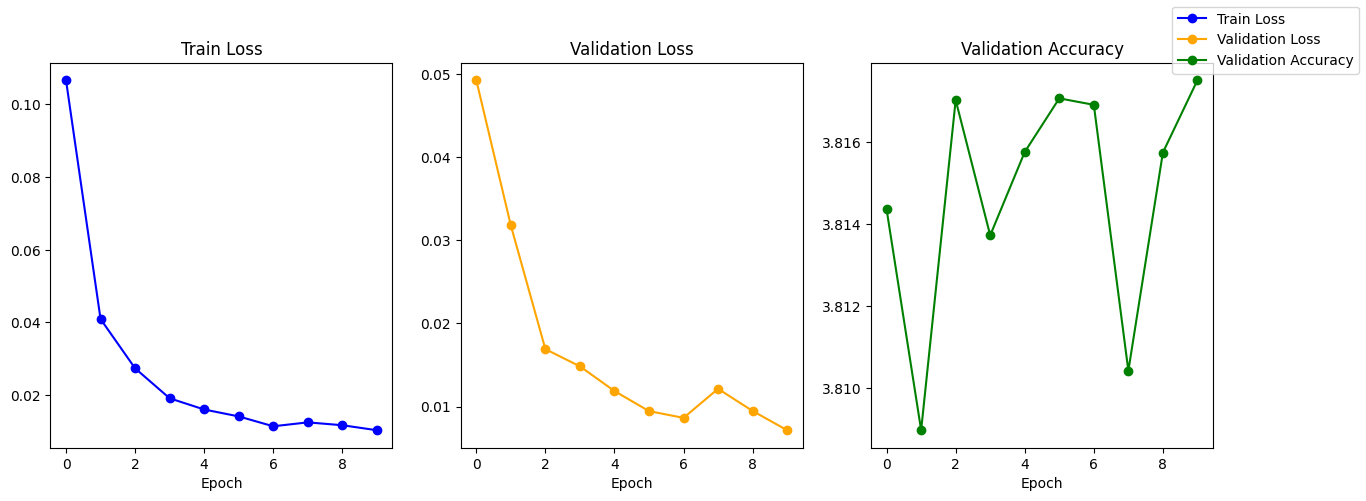

100%|██████████| 450/450 [02:10<00:00,  3.46it/s, loss=0.011]  


Train loss: 0.010435066185891628
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.009213990907913056
Got 447907436/117800960 with acc 380.22
Dice score: 3.8137440126873017


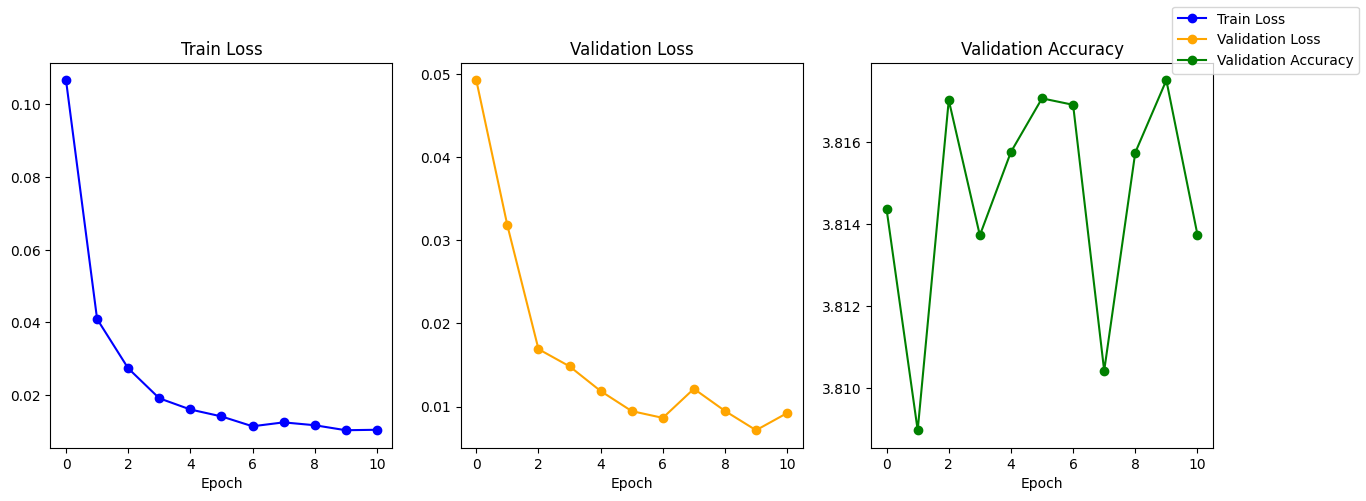

100%|██████████| 450/450 [02:09<00:00,  3.46it/s, loss=0.00494]


Train loss: 0.008404546417295933
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.00632319723510259
Got 448318999/117800960 with acc 380.57
Dice score: 3.817504301248592


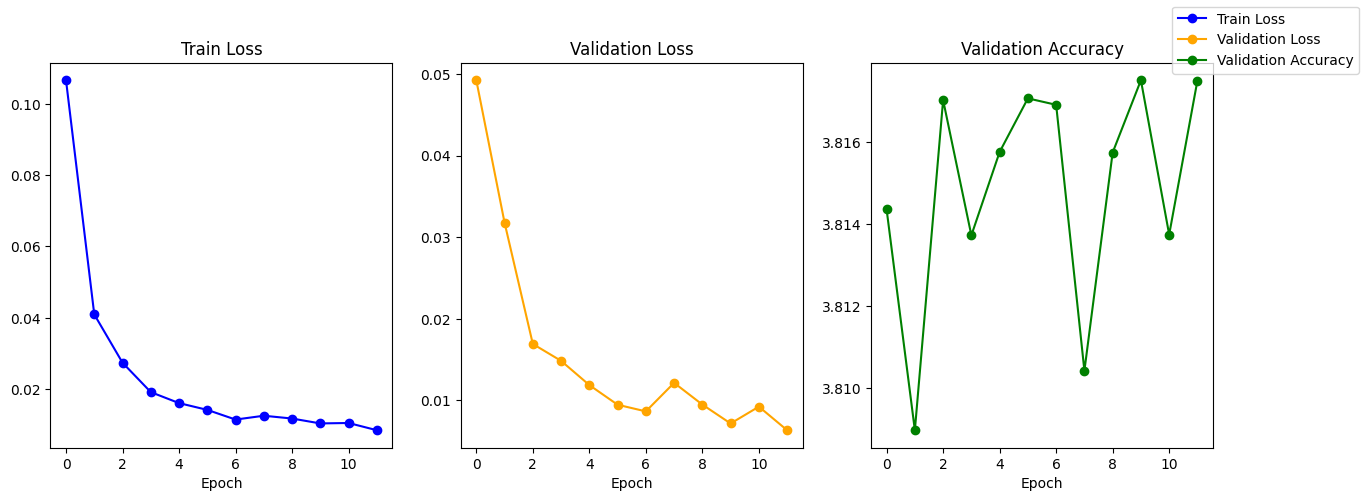

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.00616]


Train loss: 0.008157527074217796
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.006712161106196283
Got 448269614/117800960 with acc 380.53
Dice score: 3.817119514748136


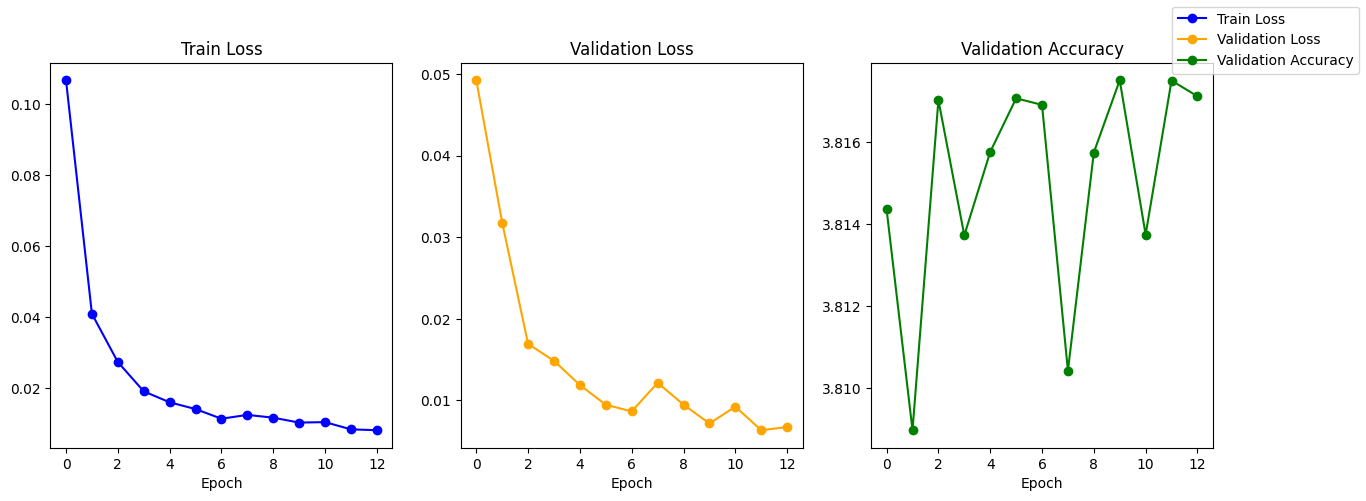

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.0125] 


Train loss: 0.010008259676396847
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.006567303455684404
Got 448304910/117800960 with acc 380.56
Dice score: 3.817385687615046


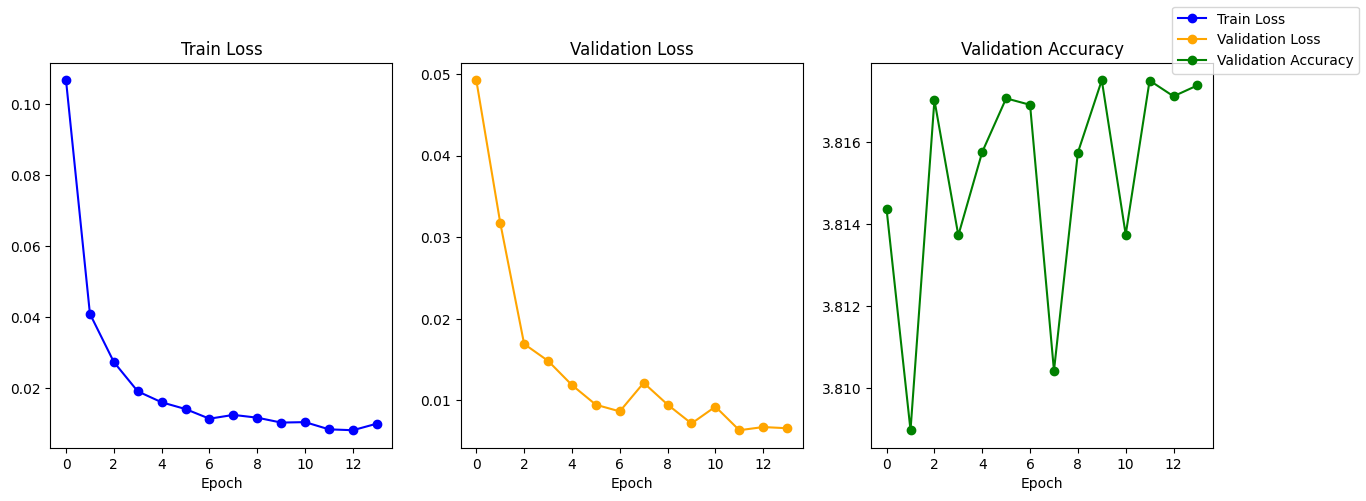

100%|██████████| 450/450 [02:10<00:00,  3.44it/s, loss=0.00512]


Train loss: 0.008764421567320824
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.006120371799455029
Got 448345126/117800960 with acc 380.60
Dice score: 3.817715521334554


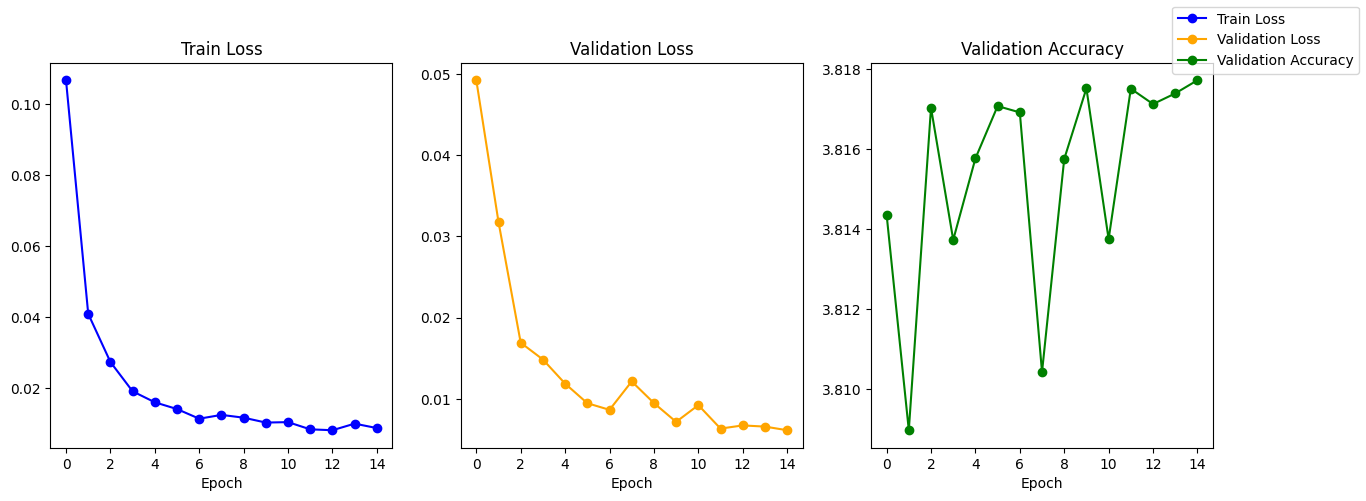

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.00629]


Train loss: 0.009278024546802044
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.008275966964158601
Got 448204399/117800960 with acc 380.48
Dice score: 3.816295561092859


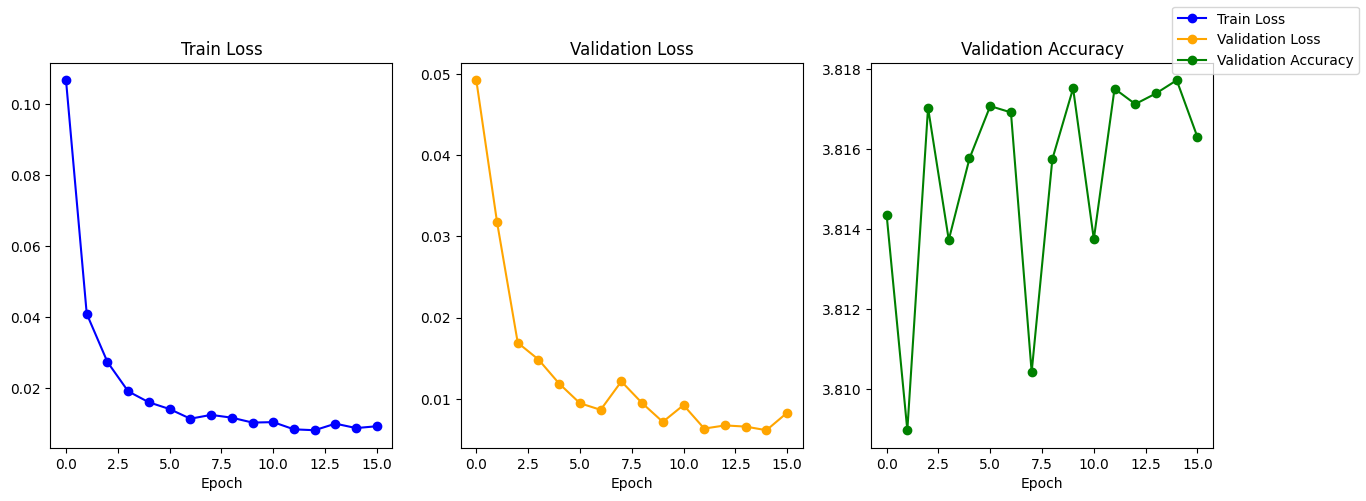

100%|██████████| 450/450 [02:11<00:00,  3.42it/s, loss=0.0224] 


Train loss: 0.00793017540127039
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005950977388293885
Got 448322504/117800960 with acc 380.58
Dice score: 3.817438866903627


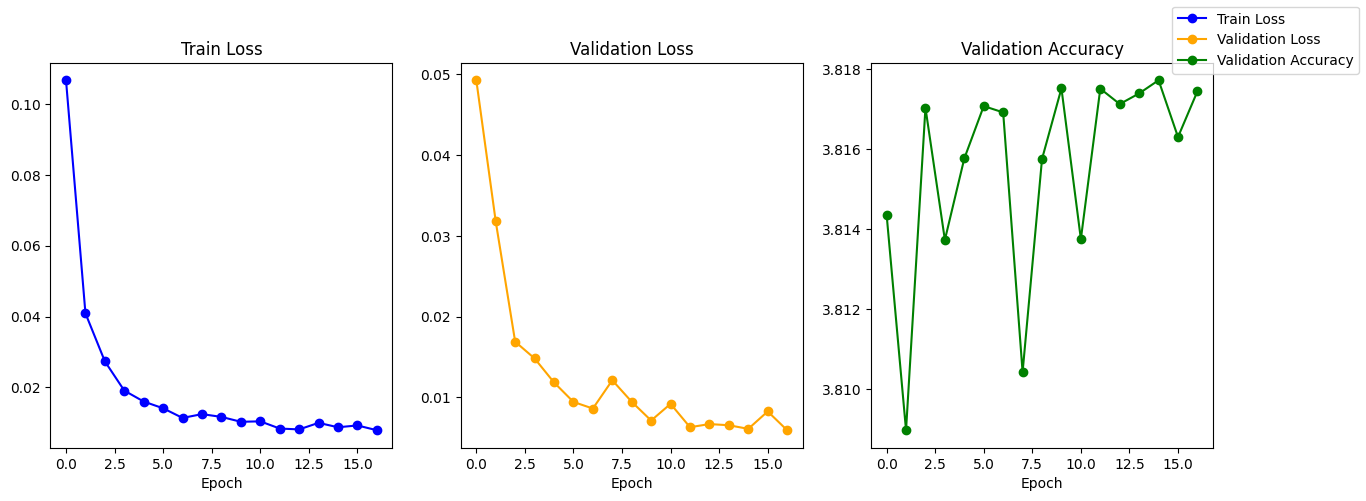

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.00819]


Train loss: 0.007004549726843834
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.0069050777467067155
Got 448222520/117800960 with acc 380.49
Dice score: 3.8166613582582674


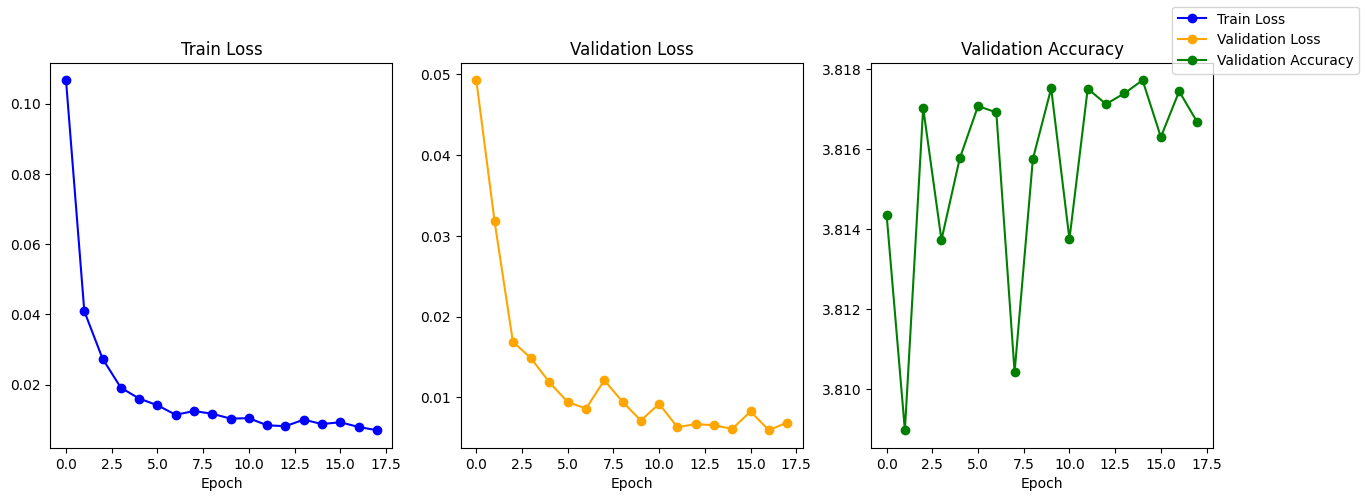

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.0061] 


Train loss: 0.008502135053277016
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005973846170283622
Got 448309167/117800960 with acc 380.56
Dice score: 3.8173366691777364


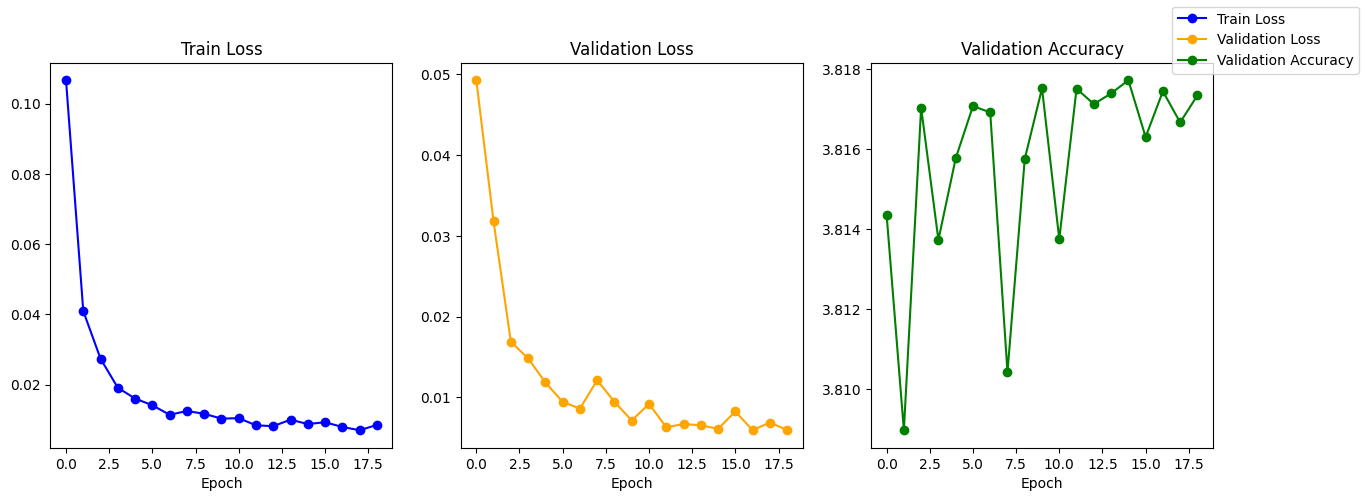

100%|██████████| 450/450 [02:10<00:00,  3.44it/s, loss=0.00642]


Train loss: 0.00796522106975317
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.00569519907916203
Got 448339280/117800960 with acc 380.59
Dice score: 3.817686543826381


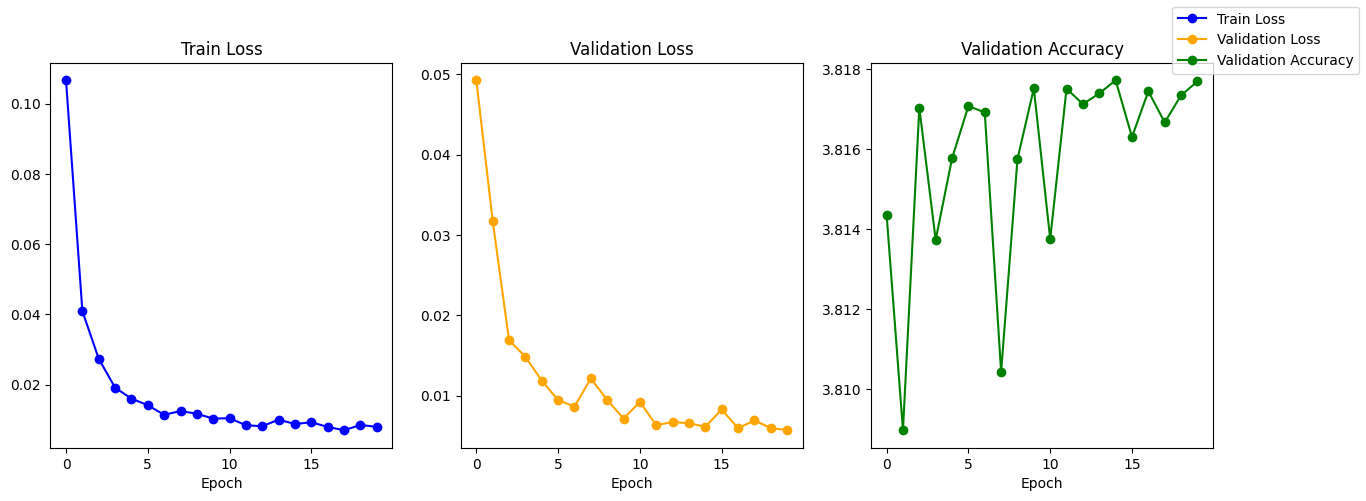

100%|██████████| 450/450 [02:11<00:00,  3.42it/s, loss=0.00748]


Train loss: 0.007123585790395737
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.006731237705954422
Got 448299905/117800960 with acc 380.56
Dice score: 3.817362513579409


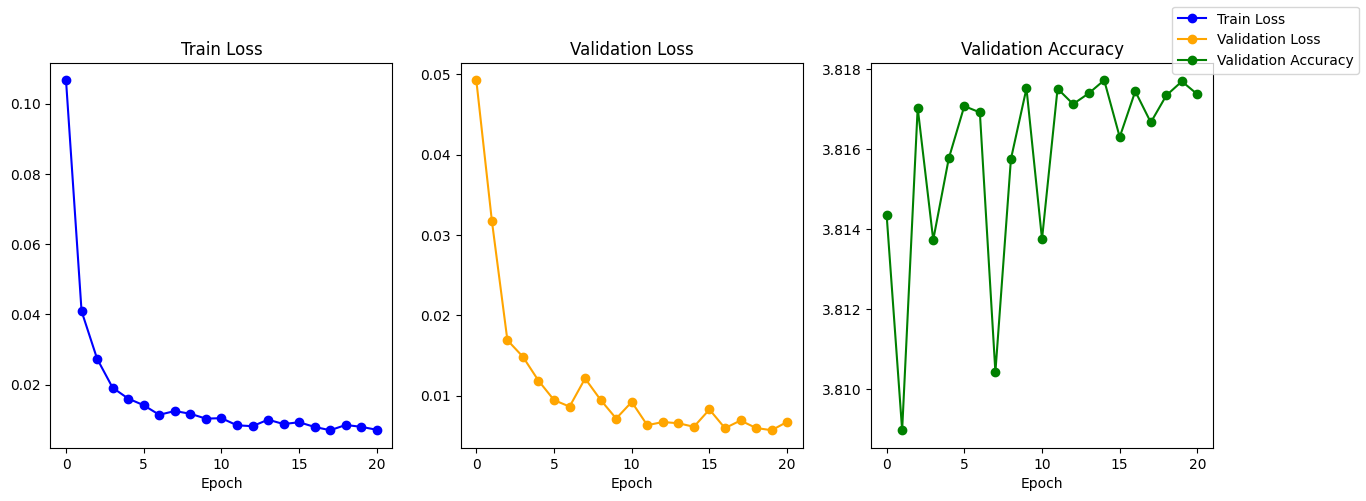

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.00883]


Train loss: 0.006662639789283276
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005674301690807374
Got 448345308/117800960 with acc 380.60
Dice score: 3.817675781376979


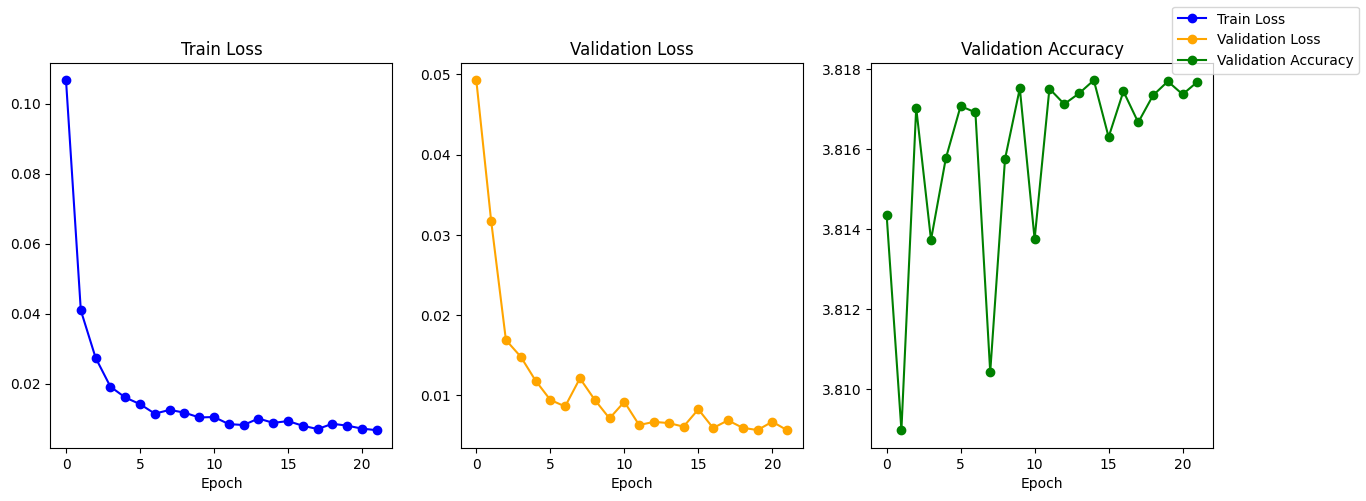

100%|██████████| 450/450 [02:10<00:00,  3.44it/s, loss=0.00643]


Train loss: 0.006515416316688061
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005673981084306005
Got 448303730/117800960 with acc 380.56
Dice score: 3.817384737706125


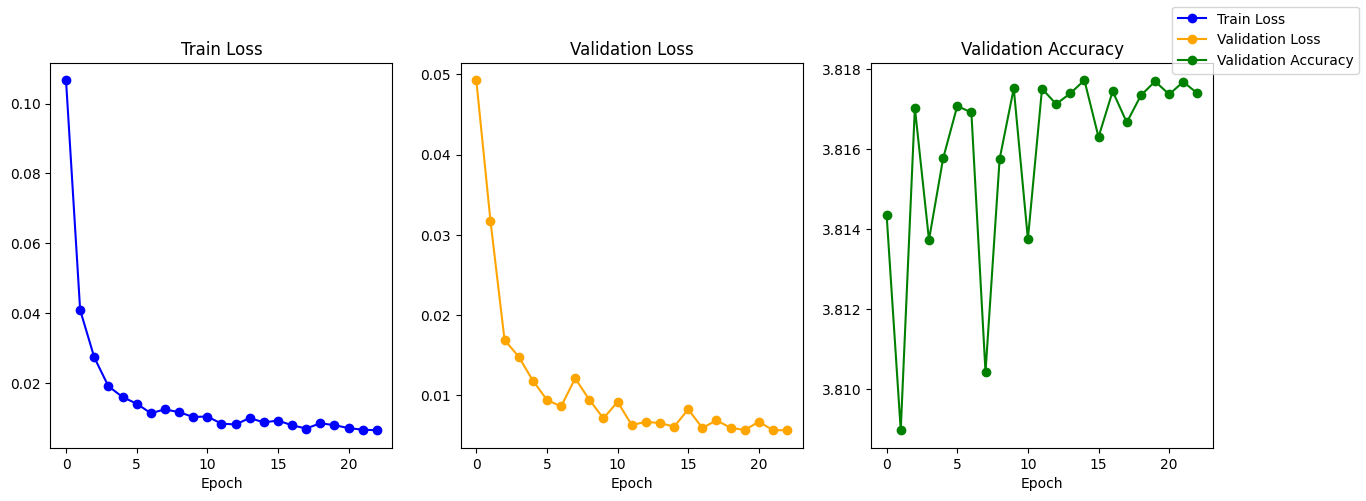

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.00489]


Train loss: 0.008093446493148804
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005461417730624173
Got 448355100/117800960 with acc 380.60
Dice score: 3.8176773627586695


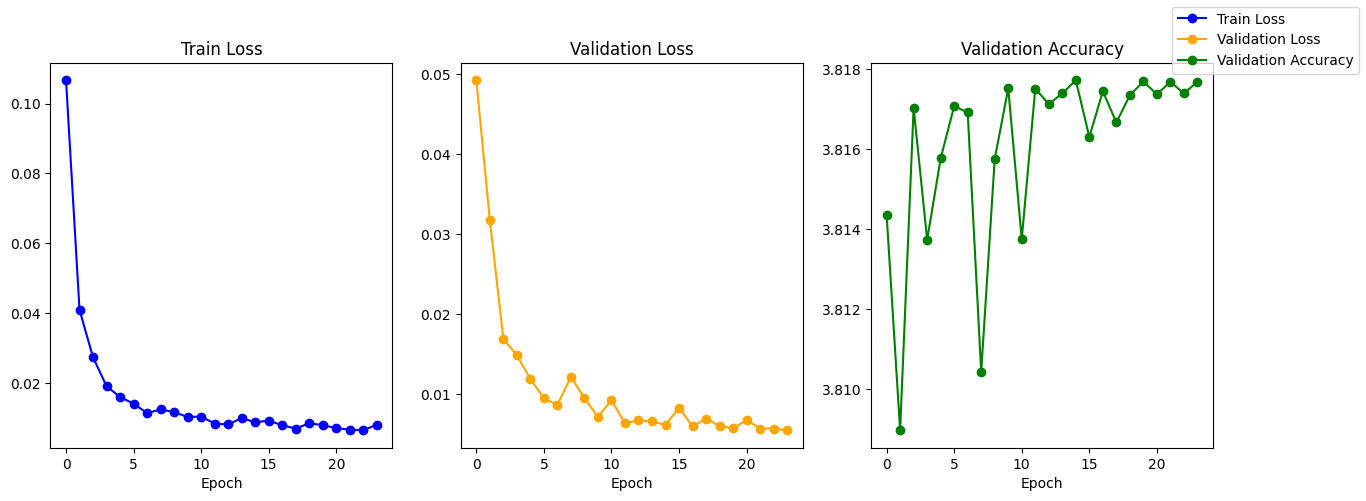

100%|██████████| 450/450 [02:09<00:00,  3.46it/s, loss=0.00961]


Train loss: 0.007542775012552738
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005844976477432702
Got 448330608/117800960 with acc 380.58
Dice score: 3.8176042547976548


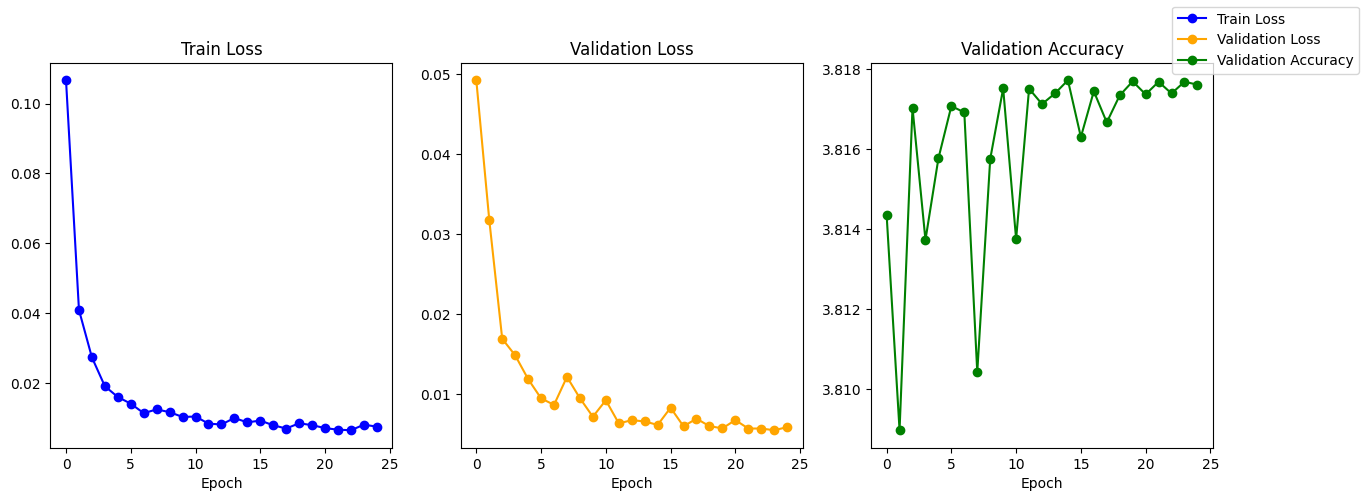

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.004]  


Train loss: 0.006768332328647375
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.008499300841203745
Got 447929109/117800960 with acc 380.24
Dice score: 3.814032360209506


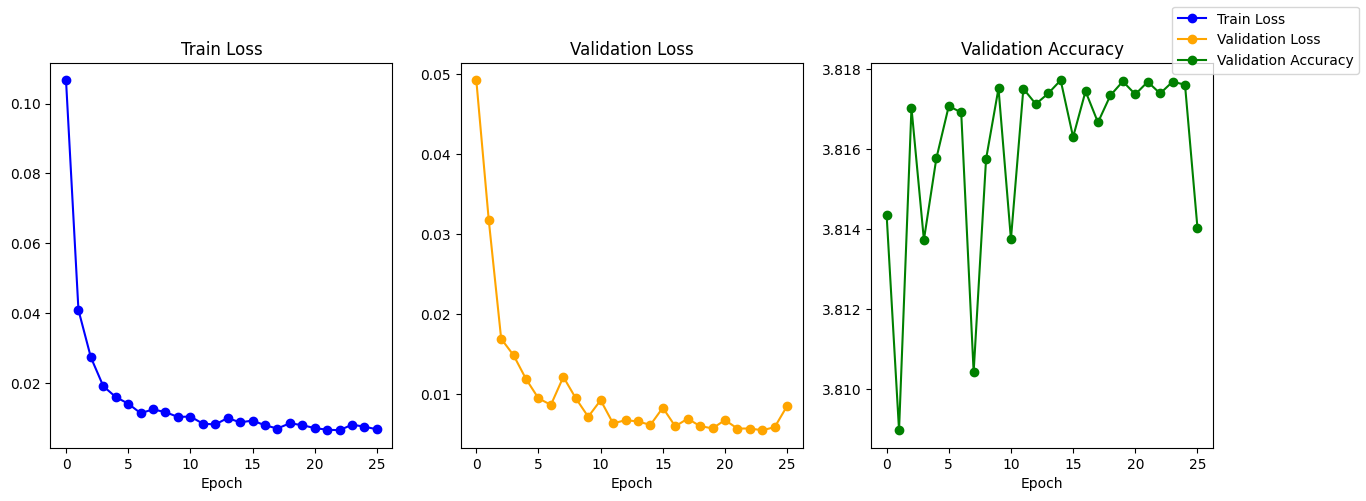

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.00464]


Train loss: 0.007097740191966295
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005374327915263786
Got 448361779/117800960 with acc 380.61
Dice score: 3.817808502438597


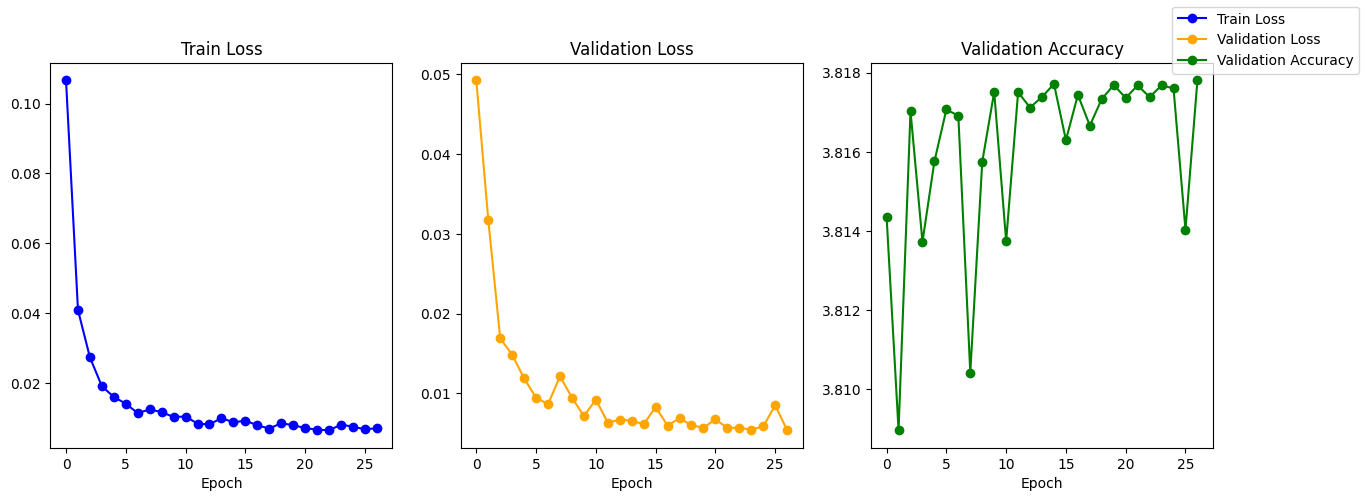

100%|██████████| 450/450 [02:10<00:00,  3.46it/s, loss=0.0129] 


Train loss: 0.006717758718878031
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005675565687710579
Got 448357972/117800960 with acc 380.61
Dice score: 3.8178177363635815


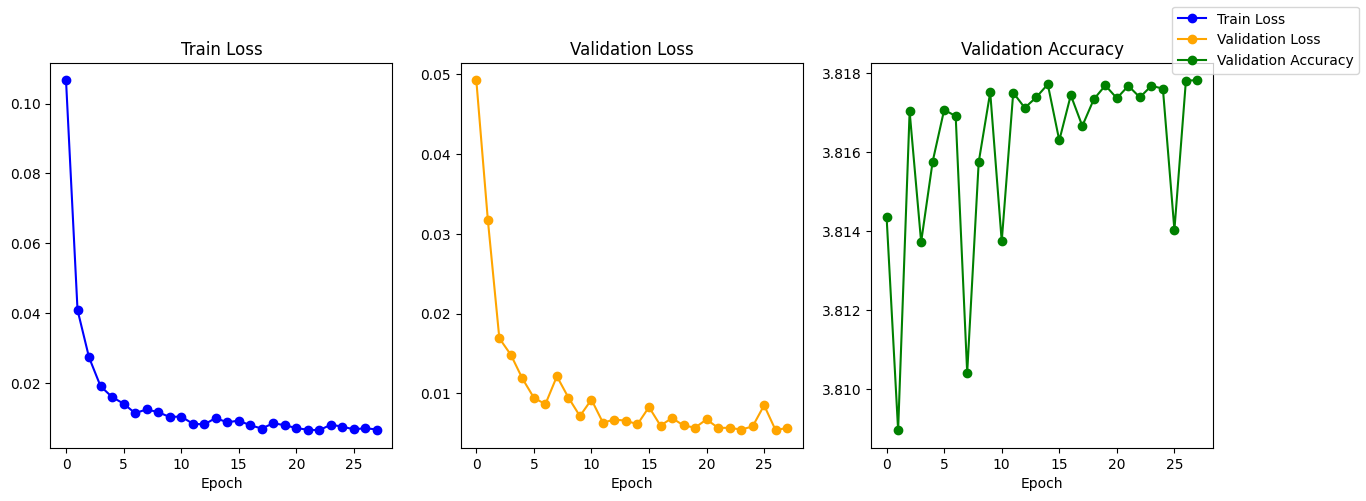

100%|██████████| 450/450 [02:10<00:00,  3.46it/s, loss=0.00749]


Train loss: 0.00613937433809042
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005457904490899166
Got 448362301/117800960 with acc 380.61
Dice score: 3.8178281605991127


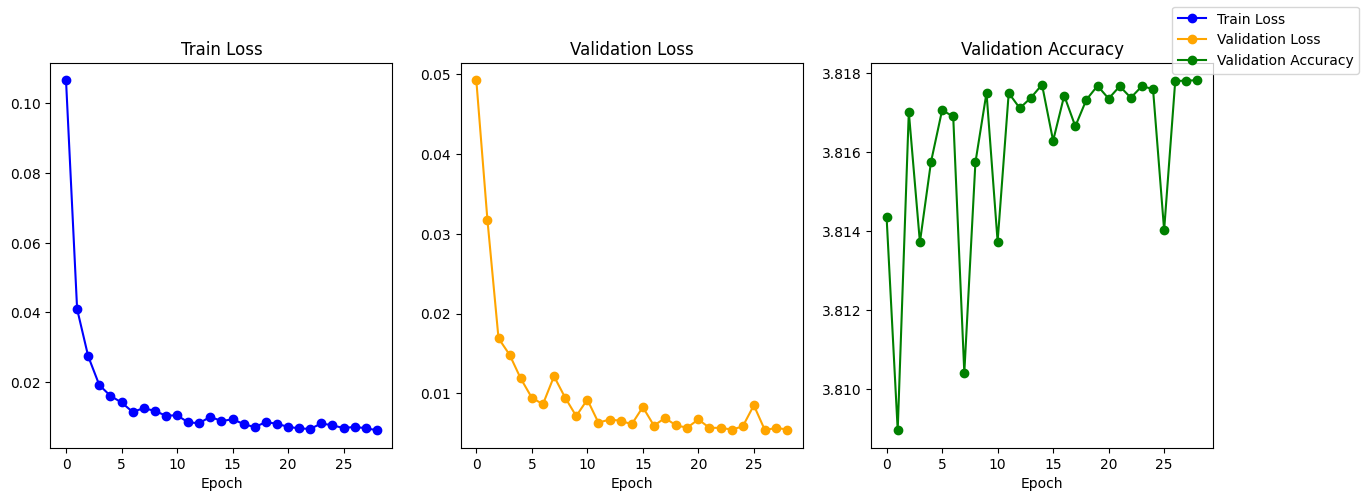

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.00517]


Train loss: 0.006121200975030661
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.006570897855535896
Got 448309154/117800960 with acc 380.56
Dice score: 3.817359681235538


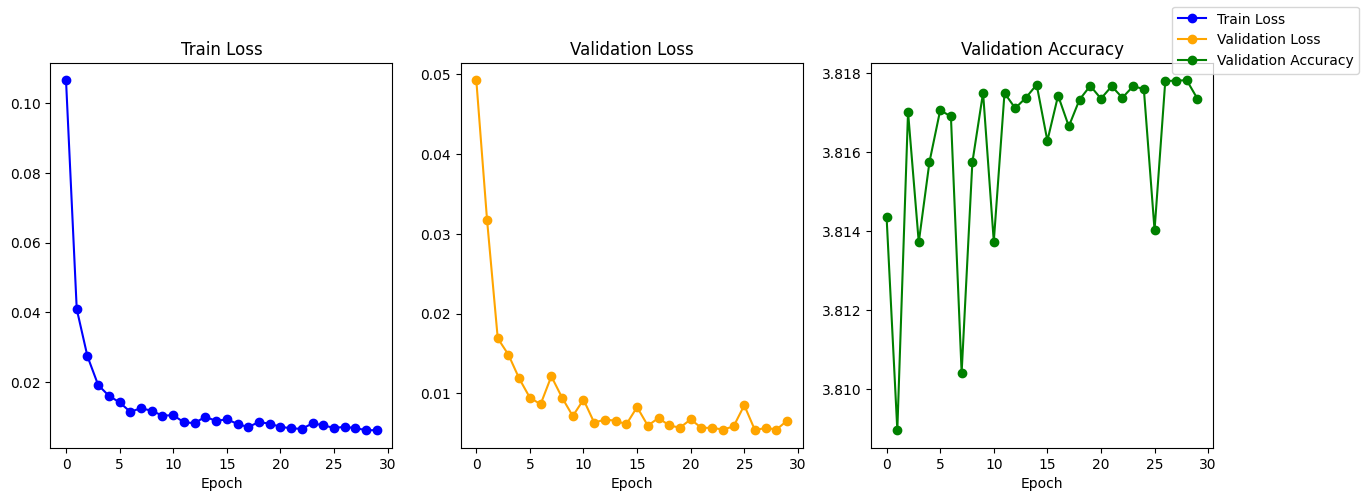

100%|██████████| 450/450 [02:10<00:00,  3.44it/s, loss=0.00399]


Train loss: 0.006693609524518251
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.010023112086376157
Got 447937719/117800960 with acc 380.25
Dice score: 3.814053087826415


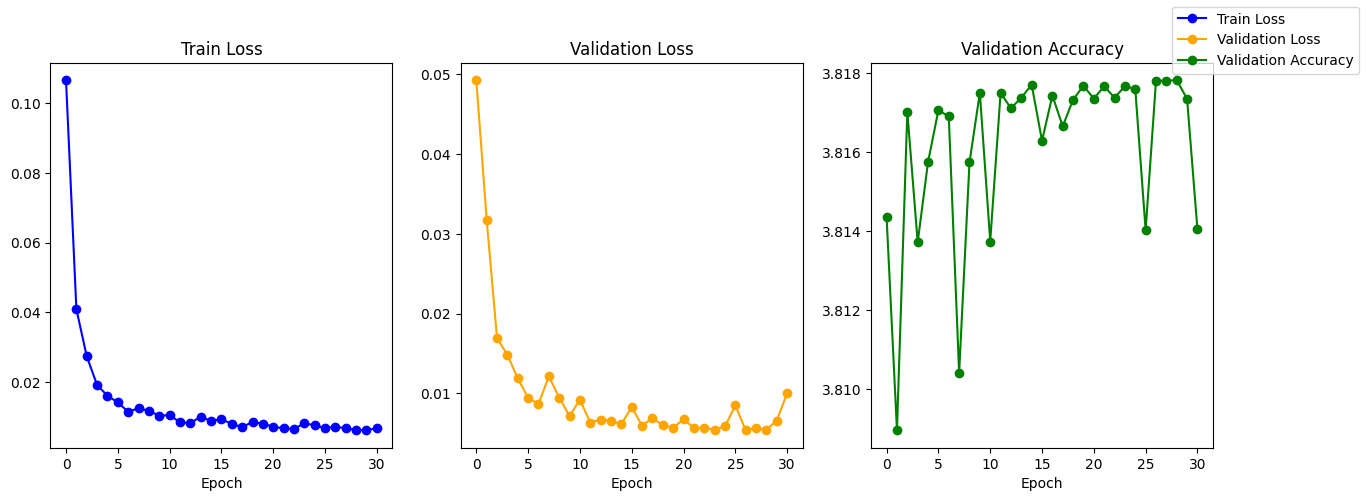

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.00468]


Train loss: 0.006393694318830967
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005919441816581411
Got 448316612/117800960 with acc 380.57
Dice score: 3.8174537816360434


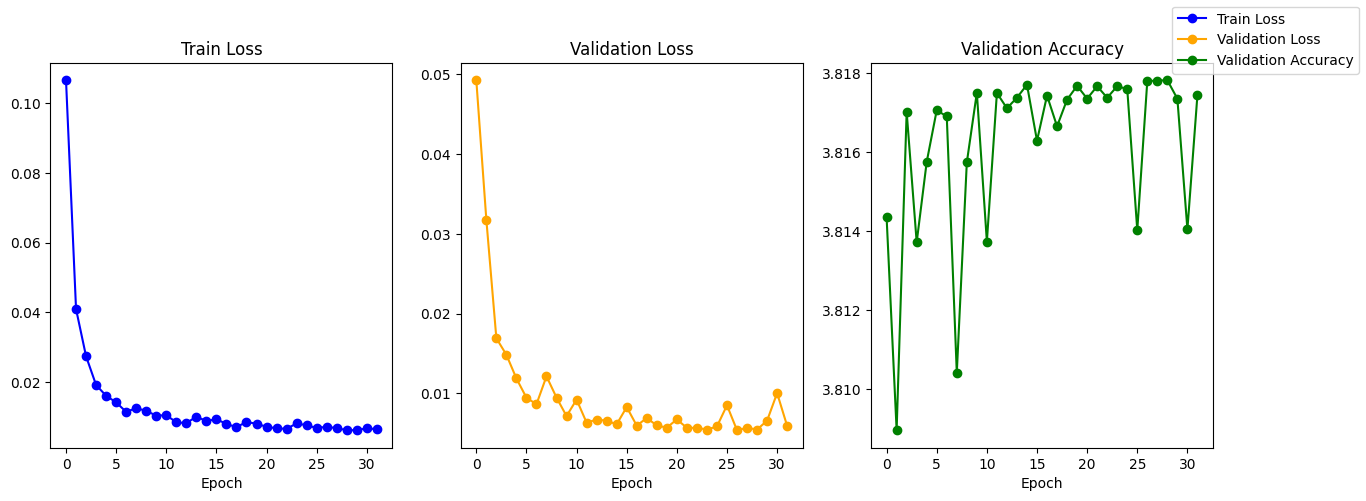

100%|██████████| 450/450 [02:09<00:00,  3.48it/s, loss=0.007]  


Train loss: 0.008072925731539726
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.007824031509214534
Got 448029984/117800960 with acc 380.33
Dice score: 3.8151840834020048


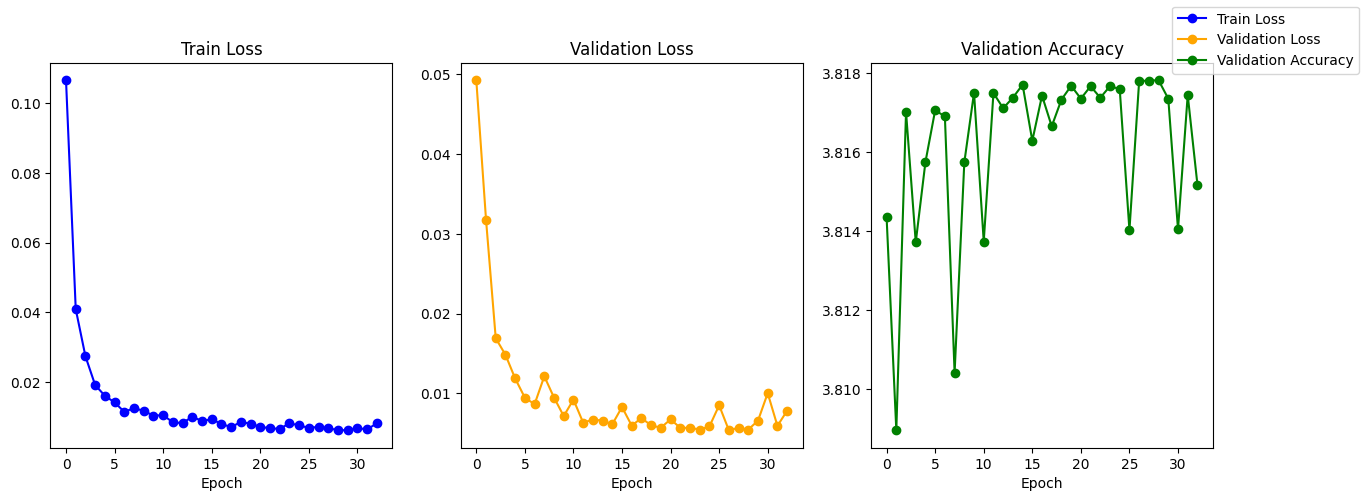

100%|██████████| 450/450 [02:09<00:00,  3.48it/s, loss=0.00715]


Train loss: 0.005984046030789614
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005311641378407972
Got 448345837/117800960 with acc 380.60
Dice score: 3.817773258255941


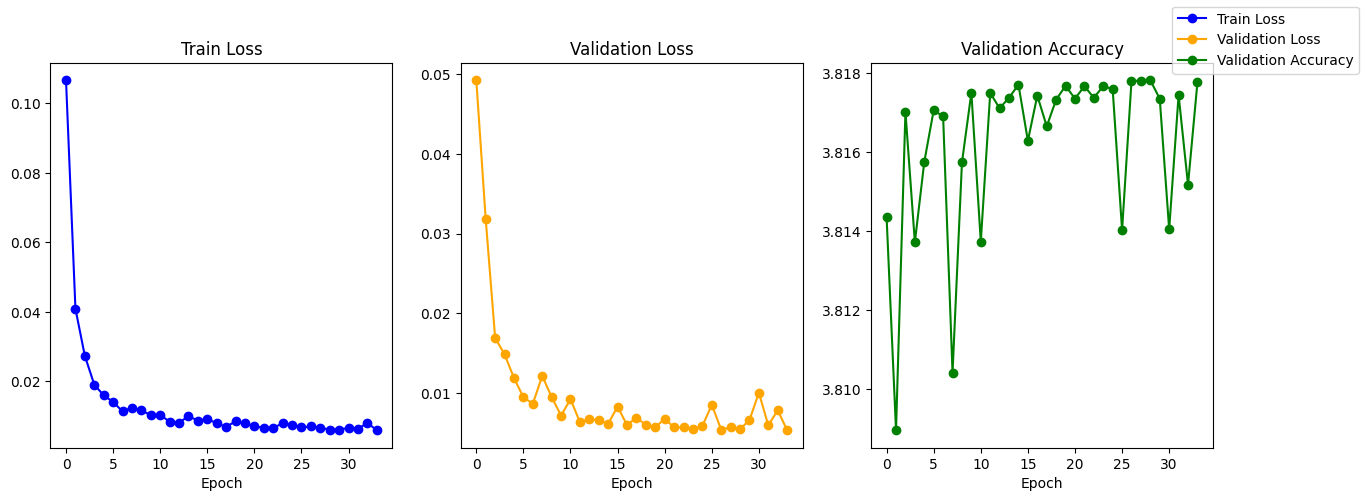

100%|██████████| 450/450 [02:08<00:00,  3.49it/s, loss=0.0044] 


Train loss: 0.006770500913262367
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005738022383944741
Got 448352990/117800960 with acc 380.60
Dice score: 3.8178110979395794


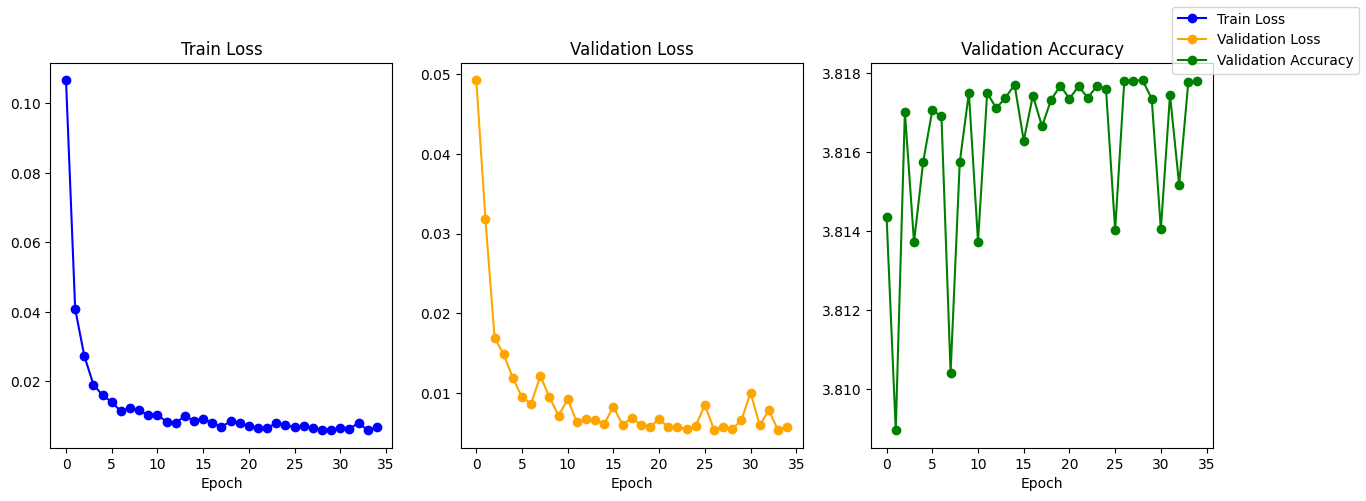

100%|██████████| 450/450 [02:09<00:00,  3.47it/s, loss=0.00444]


Train loss: 0.0069335210137069225
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005867479597472143
Got 448332037/117800960 with acc 380.58
Dice score: 3.8176093005267466


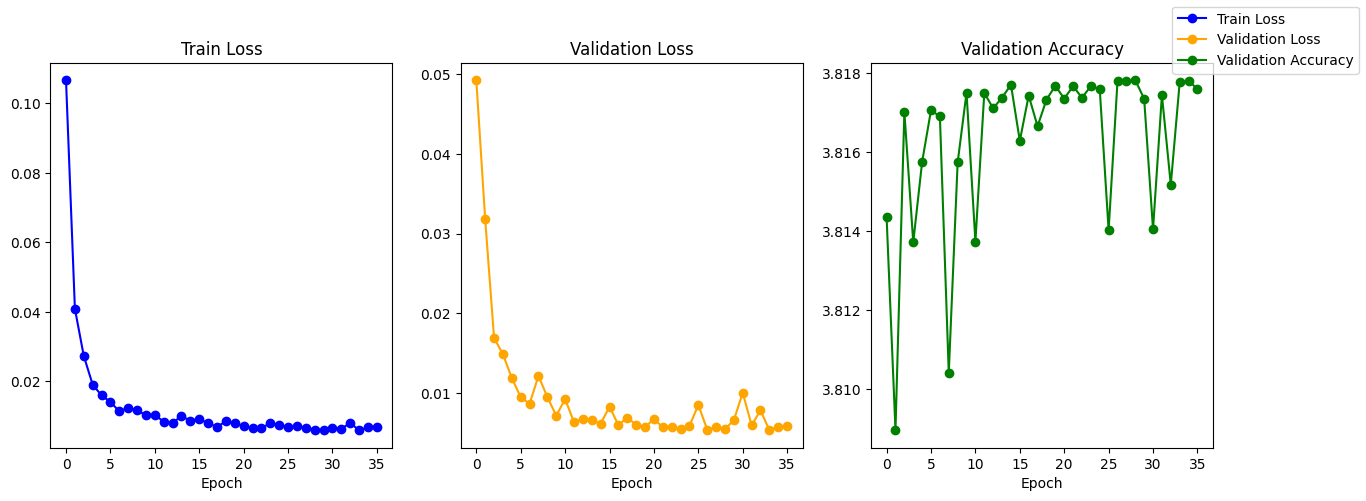

100%|██████████| 450/450 [02:08<00:00,  3.49it/s, loss=0.0105] 


Train loss: 0.007107774261385202
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005388007746093613
Got 448341813/117800960 with acc 380.59
Dice score: 3.8176338018847527


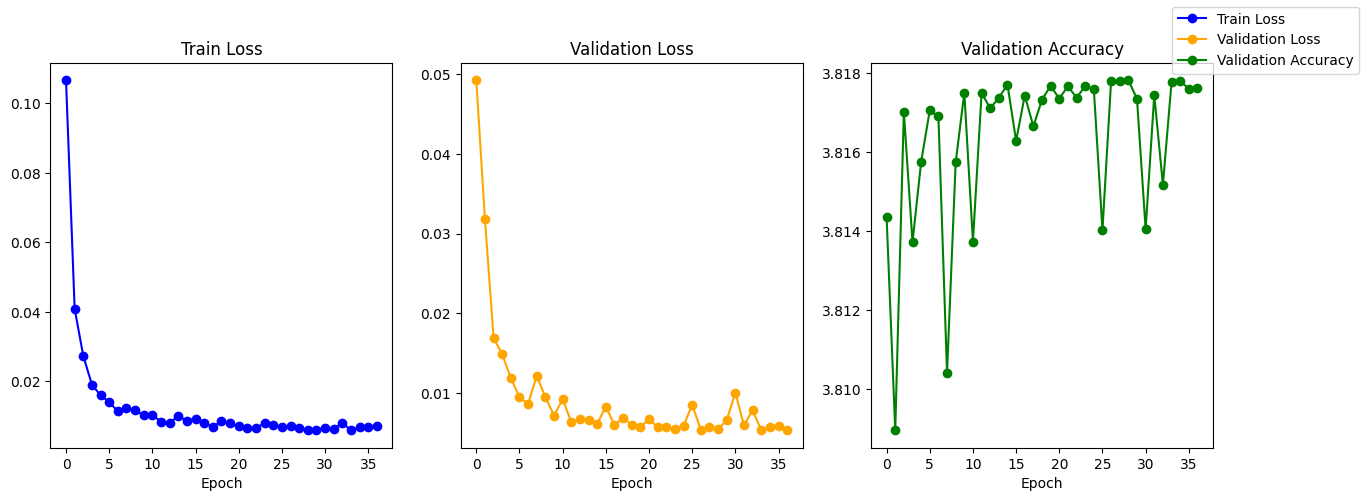

100%|██████████| 450/450 [02:11<00:00,  3.43it/s, loss=0.00428]


Train loss: 0.005980640649795532
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.0050921716426371765
Got 448371947/117800960 with acc 380.62
Dice score: 3.8179582464195305


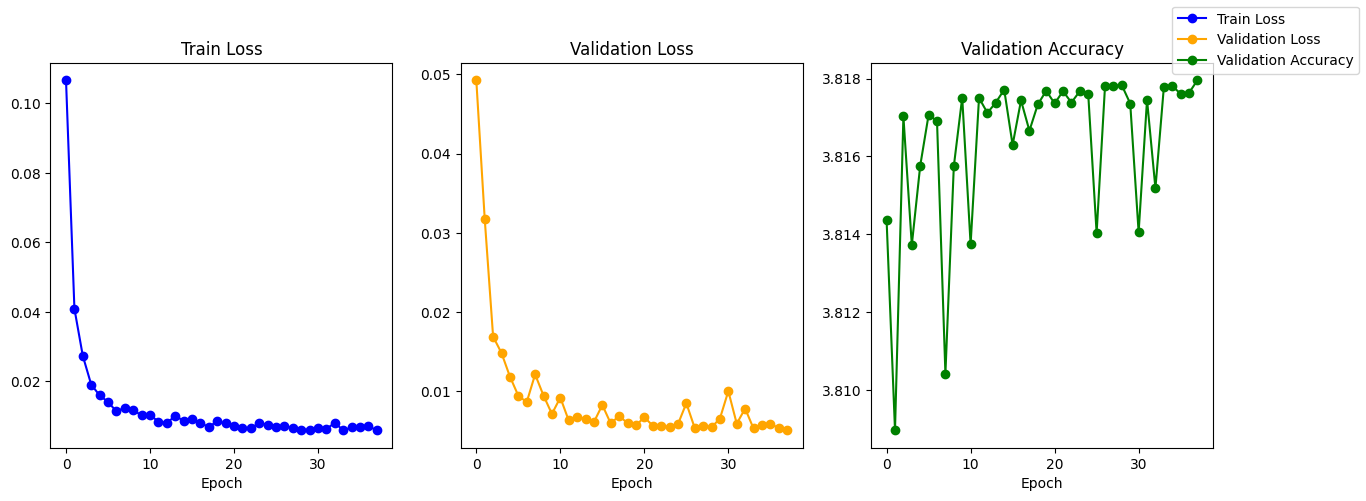

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.00983]


Train loss: 0.00579447578638792
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005230982014567522
Got 448311255/117800960 with acc 380.57
Dice score: 3.8174449689430476


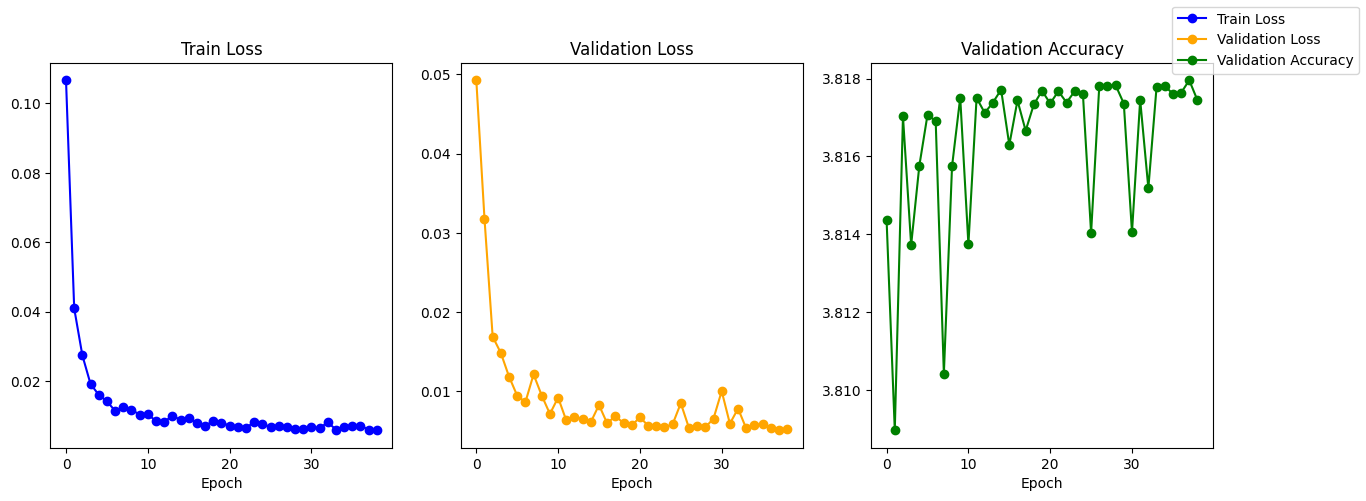

100%|██████████| 450/450 [02:09<00:00,  3.47it/s, loss=0.00983]


Train loss: 0.005664195399731398
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005268287447926581
Got 448353900/117800960 with acc 380.60
Dice score: 3.817801785805401


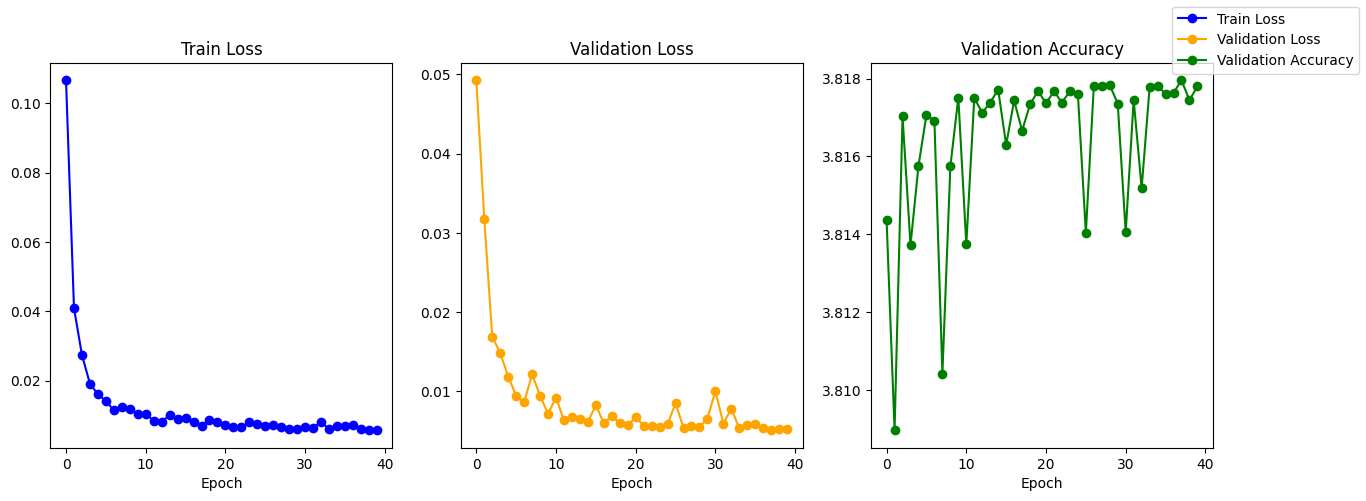

100%|██████████| 450/450 [02:13<00:00,  3.37it/s, loss=0.0163] 


Train loss: 0.006083078682422638
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005305350317595914
Got 448370524/117800960 with acc 380.62
Dice score: 3.817956272739928


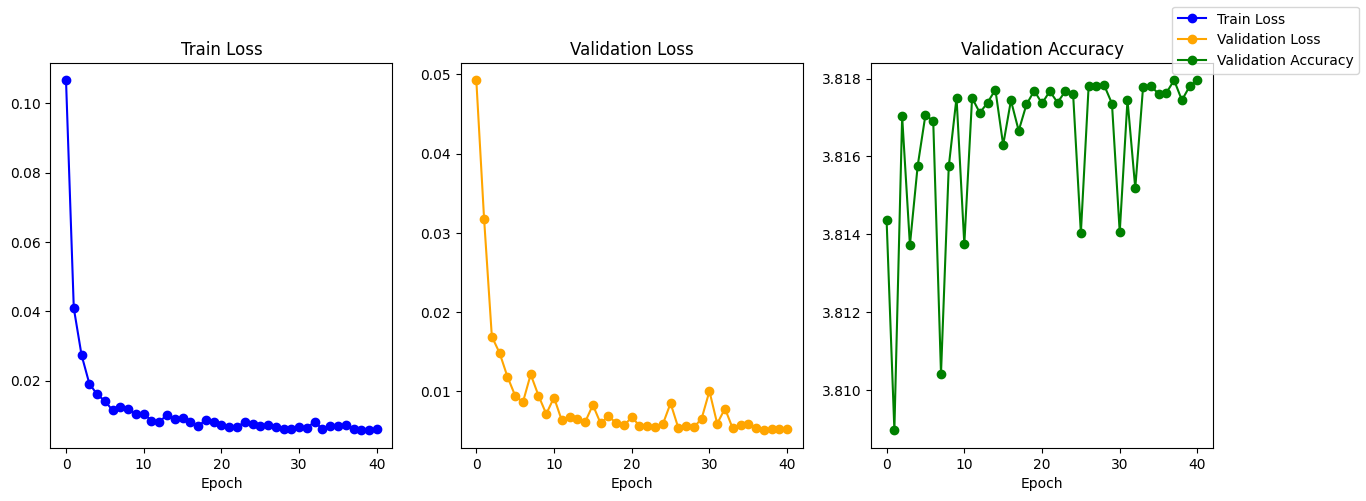

100%|██████████| 450/450 [02:10<00:00,  3.46it/s, loss=0.00531]


Train loss: 0.00671709468588233
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.0065147818350549105
Got 448231777/117800960 with acc 380.50
Dice score: 3.8167844528870987


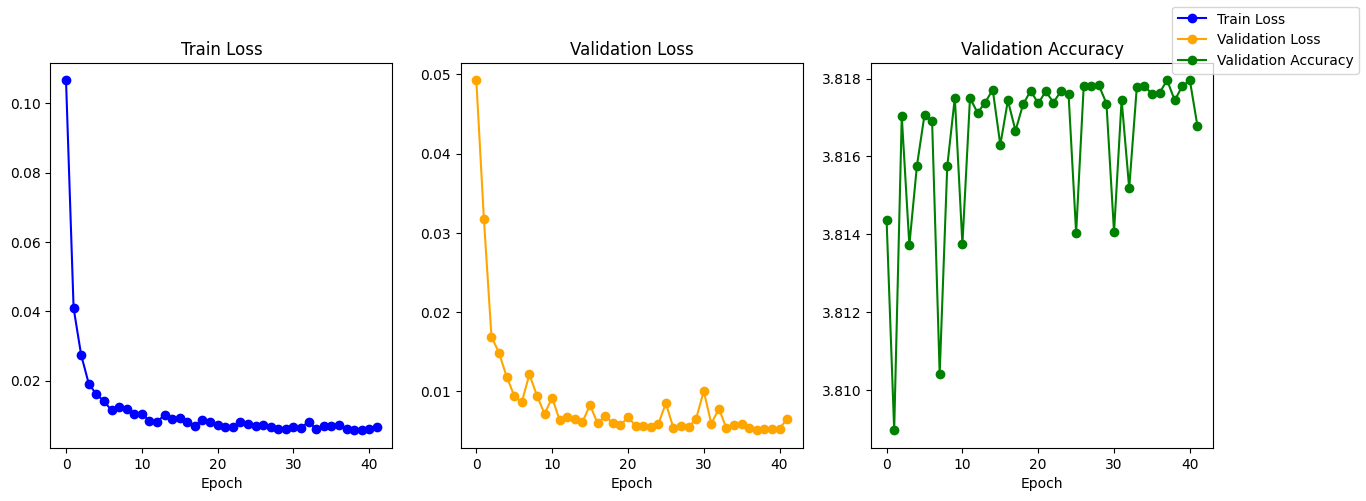

100%|██████████| 450/450 [02:10<00:00,  3.44it/s, loss=0.00532]


Train loss: 0.006066648289561272
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.008303848749313615
Got 448021001/117800960 with acc 380.32
Dice score: 3.814742758965932


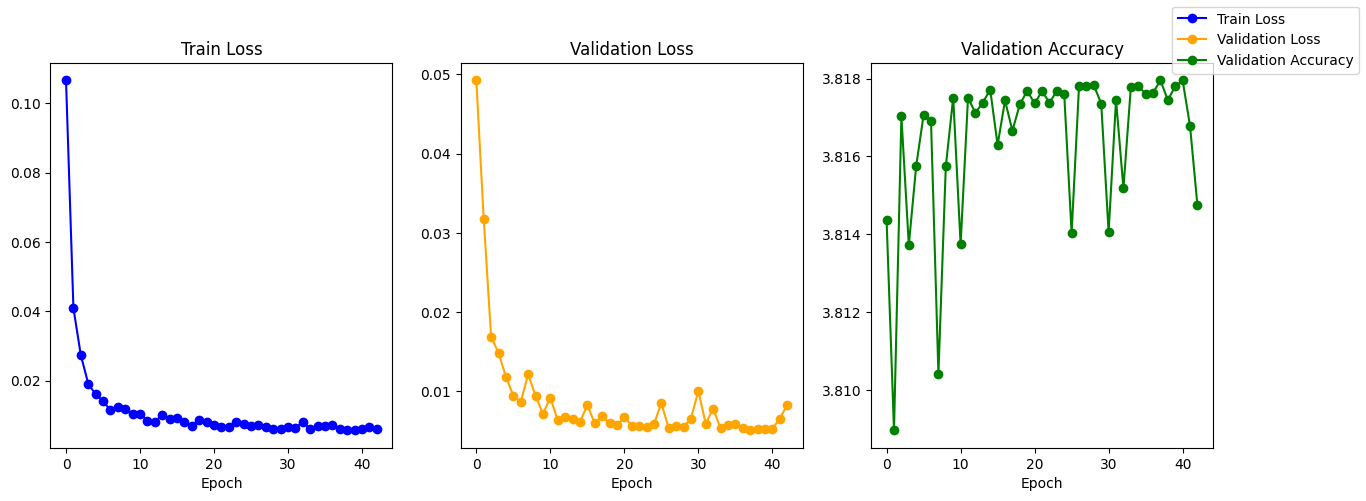

100%|██████████| 450/450 [02:10<00:00,  3.44it/s, loss=0.00604]


Train loss: 0.0056973714381456375
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.00507832614762462
Got 448380694/117800960 with acc 380.63
Dice score: 3.817881779682637


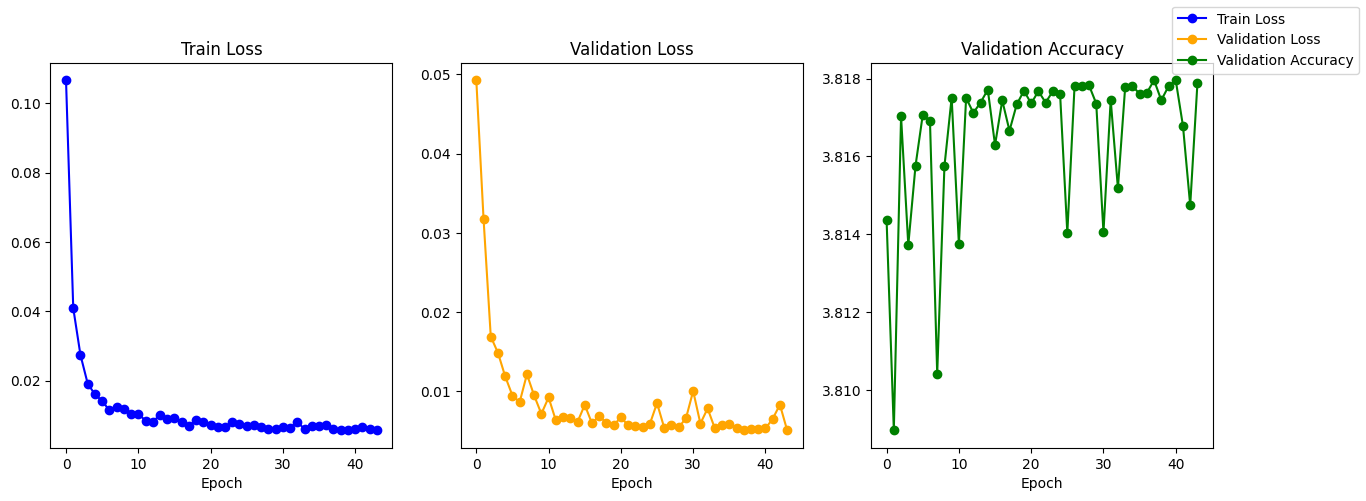

100%|██████████| 450/450 [02:10<00:00,  3.45it/s, loss=0.00533]


Train loss: 0.0055559854954481125
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005961169887829294
Got 448280521/117800960 with acc 380.54
Dice score: 3.817198330227707


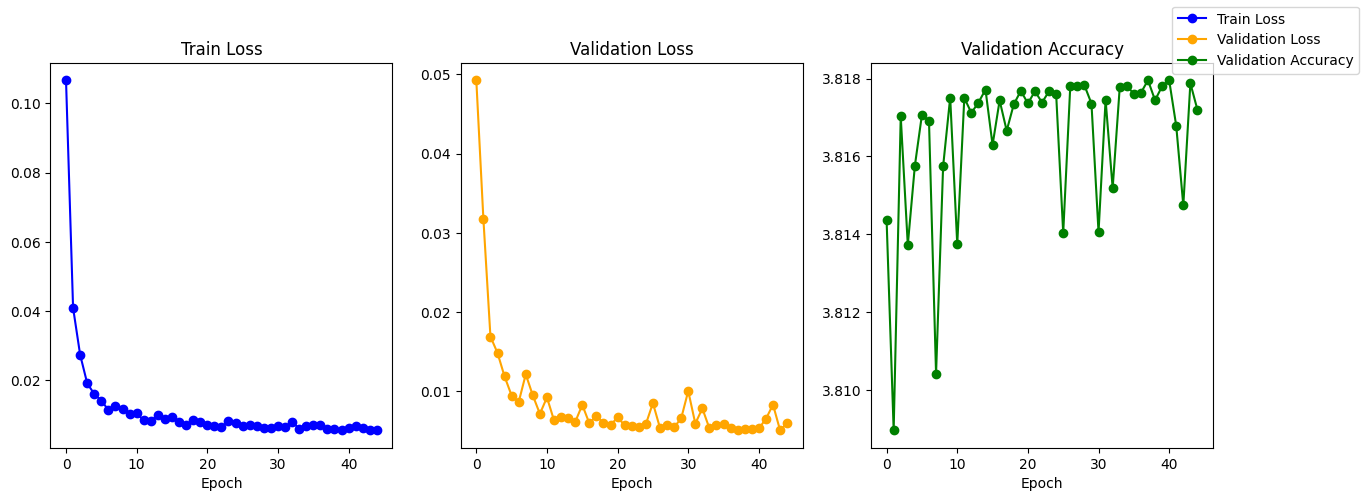

100%|██████████| 450/450 [02:09<00:00,  3.46it/s, loss=0.00451]


Train loss: 0.005734468810260296
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.004919639485939981
Got 448390479/117800960 with acc 380.63
Dice score: 3.8181441763102244


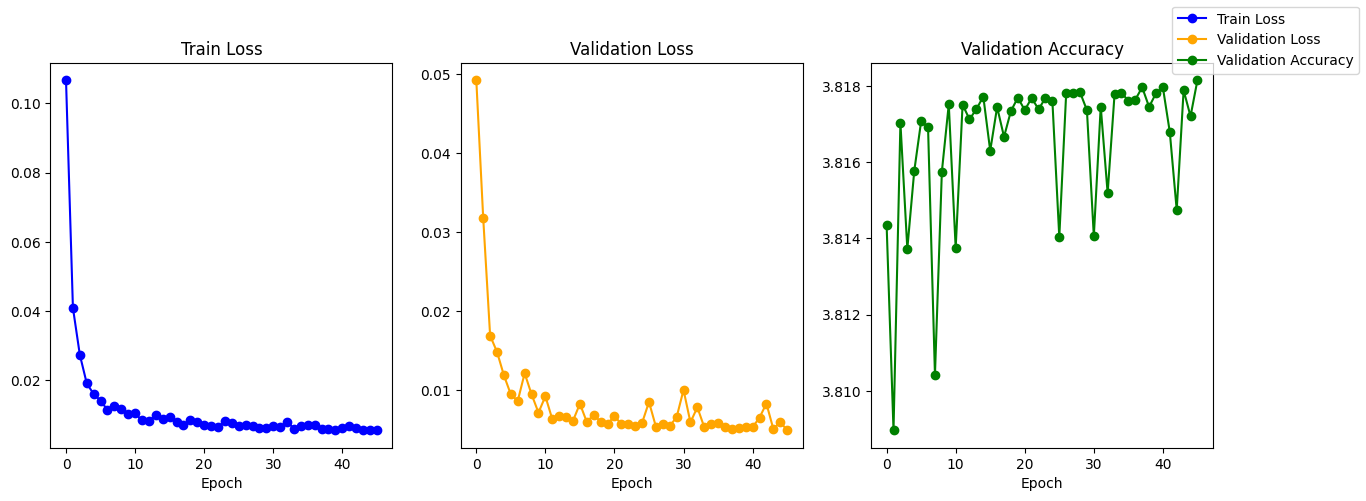

100%|██████████| 450/450 [02:09<00:00,  3.48it/s, loss=0.00594]


Train loss: 0.005584400612860918
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005127010474632079
Got 448356629/117800960 with acc 380.61
Dice score: 3.817846952898889


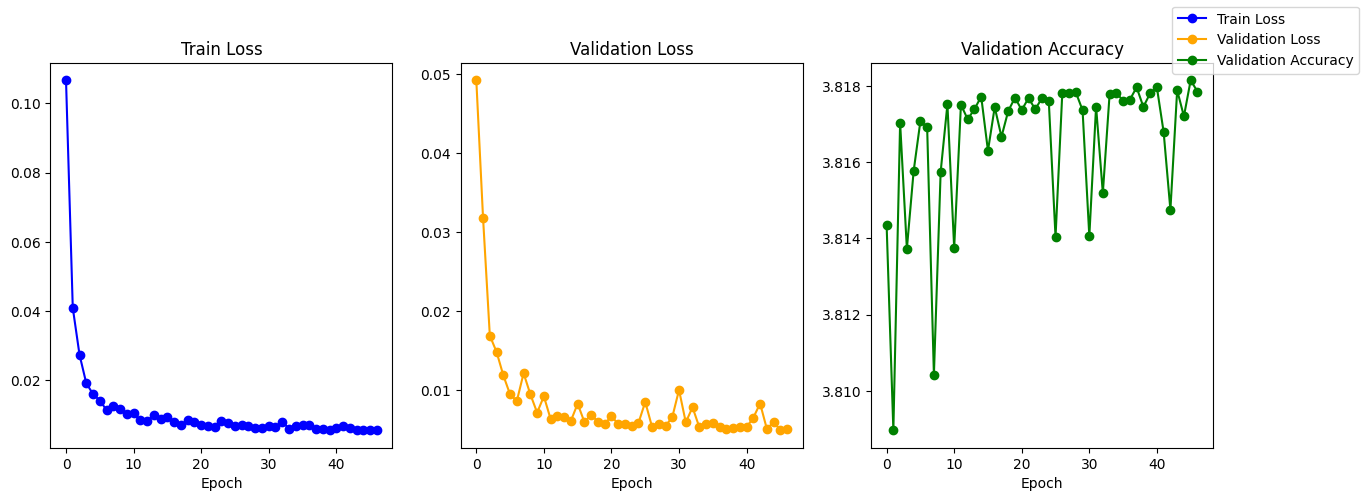

100%|██████████| 450/450 [02:09<00:00,  3.48it/s, loss=0.00528]


Train loss: 0.00560882268473506
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.005311859606892633
Got 448347673/117800960 with acc 380.60
Dice score: 3.8177807518916187


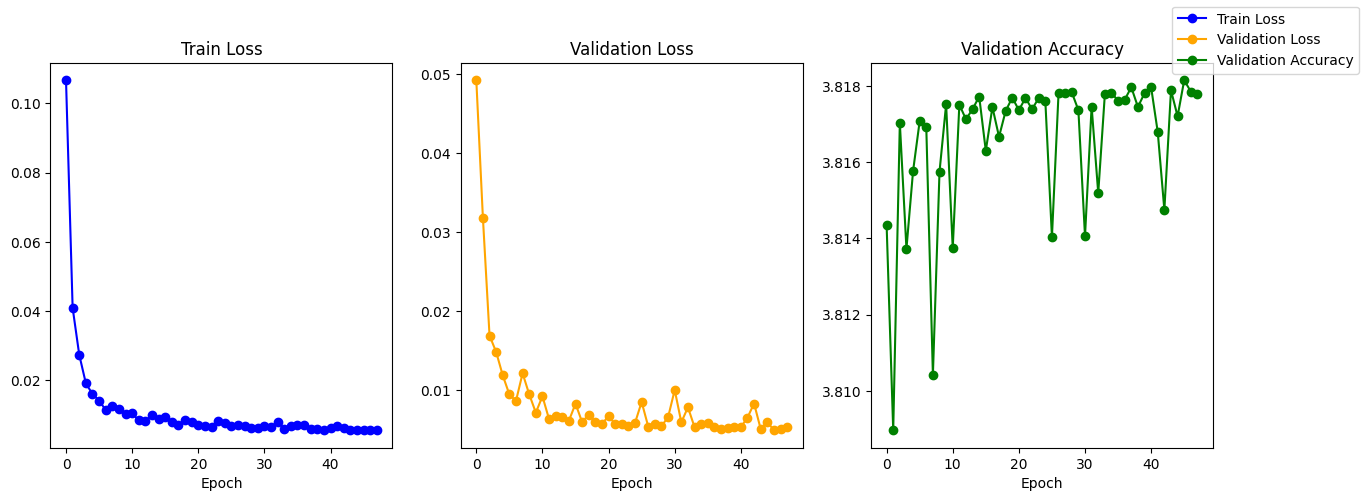

100%|██████████| 450/450 [02:09<00:00,  3.46it/s, loss=0.00612]


Train loss: 0.0065047298558056355
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.00684173687895215
Got 448210509/117800960 with acc 380.48
Dice score: 3.8165114280557257


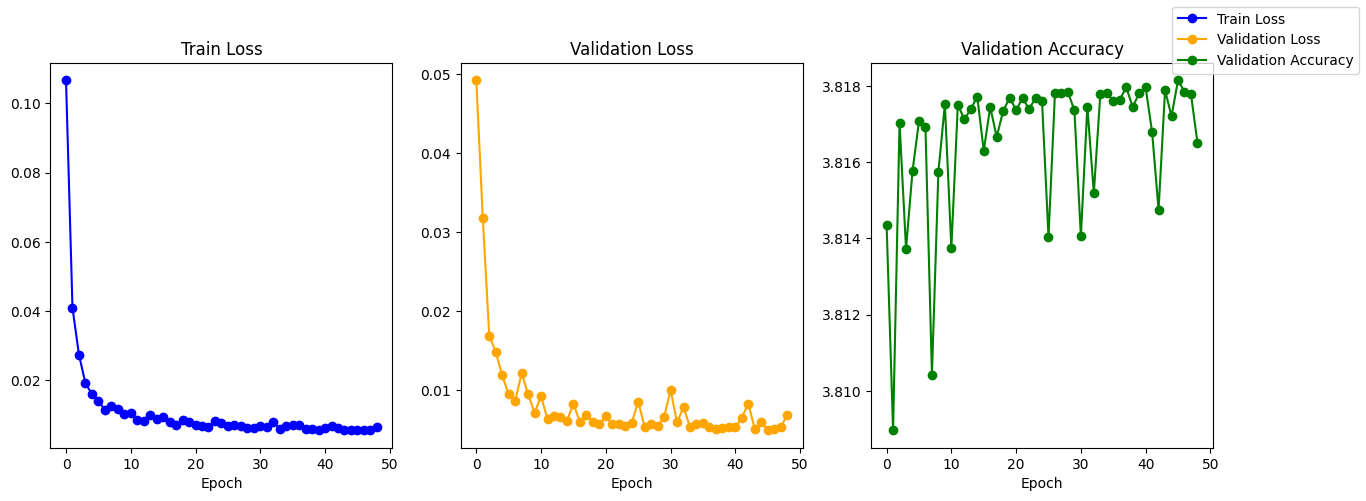

100%|██████████| 450/450 [02:09<00:00,  3.47it/s, loss=0.00383]


Train loss: 0.00568343186751008
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Validation loss: 0.0048630644463197445
Got 448380226/117800960 with acc 380.63
Dice score: 3.818039490813798


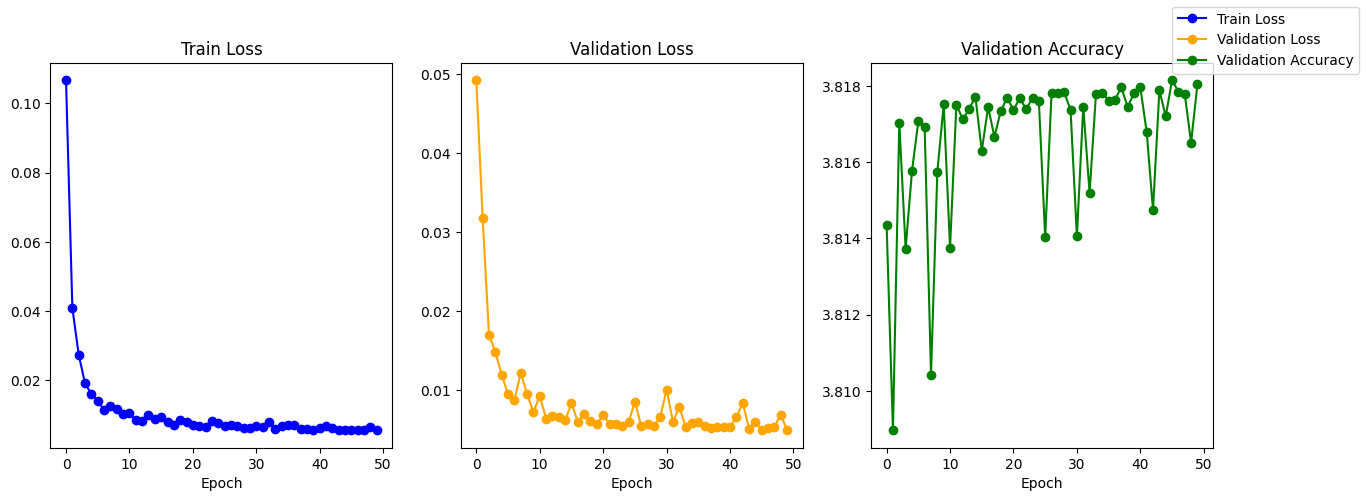

In [27]:
hyper_parameters = HyperParameters(learning_rate = 1e-4, batch_size = 4, epoch_numbers = 50)
run_training(hyper_parameters)

After running the program we can see that the loss and validation curves are coversing in the plot from that we can say that the model is working properly. The training loss is reduced significantly. Validation loss is also reduced similarly which suggests the model isn't overfitted yet. Validation accuracy is increasing which suggest the model's performence can improved over time. Moreover after 50 epochs the model may start to overfit, when the training loss will decrease but validation loss will increse and we should stop the model training then. 

# Evaluation

=> Loading checkpoint
=> Checkpoint loaded successfully
y size : torch.Size([4, 1, 128, 256])
preds size: torch.Size([4, 1, 128, 256])


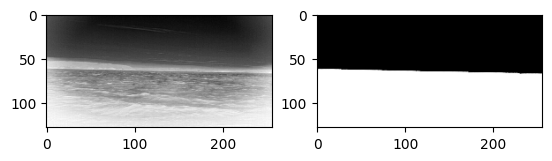

In [39]:
import albumentations as A

model = UNET().to(DEVICE)
checkpoint = torch.load(CHECKPOINT_PATH)
load_checkpoint(checkpoint, model)

# Move the model to the same device as the input data (GPU)
model = model.to(DEVICE)

# Rest of your code...
val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_ds = HorizonDataset(
    image_dir=VAL_IMG_DIR,
    mask_dir=VAL_MASK_DIR,
    transform=val_transforms
)

# Move the input data to the same device as the model (GPU)
val_loader = DataLoader(
    val_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=True,
    shuffle=False
)

val_images, val_masks = next(iter(val_loader))
val_images = val_images.to(DEVICE)

data = val_images
y = model(data)

preds = torch.sigmoid(y)
print(f"y size : {y.size()}")
print(f"preds size: {preds.size()}")

# Move the predictions back to the CPU for visualization if needed
preds = preds.cpu().detach().numpy()

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(val_images[1][0].cpu().numpy(), cmap="gray")
f.add_subplot(1, 2, 2)
plt.imshow(preds[1][0], cmap='gray')
plt.show(block=True)


In [33]:
# Save and Download Files
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/Save/ (stored 0%)
  adding: kaggle/working/Save/validation_34_0.png (deflated 6%)
  adding: kaggle/working/Save/validation_4_1.png (deflated 6%)
  adding: kaggle/working/Save/validation_37_2.png (deflated 7%)
  adding: kaggle/working/Save/validation_13_0.png (deflated 6%)
  adding: kaggle/working/Save/validation_2_0.png (deflated 5%)
  adding: kaggle/working/Save/validation_30_1.png (deflated 6%)
  adding: kaggle/working/Save/validation_46_2.png (deflated 7%)
  adding: kaggle/working/Save/validation_39_3.png (deflated 7%)
  adding: kaggle/working/Save/validation_40_2.png (deflated 7%)
  adding: kaggle/working/Save/validation_9_2.png (deflated 7%)
  adding: kaggle/working/Save/Accuracy_15.png (deflated 9%)
  adding: kaggle/working/Save/validation_30_2.png (deflated 6%)
  adding: kaggle/working/Save/validation_21_3.png (deflated 7%)
  adding: kaggle/working/Save/validation_1_2.png (deflated 6%)
  adding: kaggle/working/Save/A